In [1]:
from nearline_helpers import *
%jsroot on

Welcome to JupyROOT 6.26/10


(<Figure size 640x480 with 1 Axes>, <Axes: >)

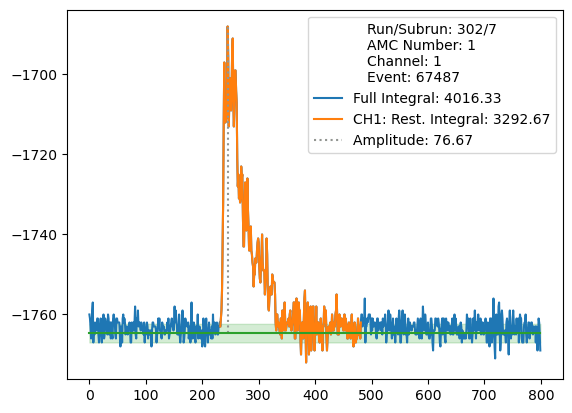

In [2]:
f2 = r.TFile("../bin/run00302_00007.mid.root")
t = f2.Get("tree")
t.GetEntry(0)
wf = t.lyso_integrals[0]
plot_integral(wf)
# plt.plot(samples,)

In [3]:
infile = './traces_raw.root'
f = uproot.open(infile)
f.keys()

['template_amc_01_channel_00;1',
 'template_amc_01_channel_01;1',
 'template_amc_01_channel_02;1',
 'template_amc_01_channel_03;1',
 'template_amc_01_channel_04;1']

In [4]:
channel = 0
h = f[f'template_amc_01_channel_{channel:02}'].to_hist()
h

Hist(
  Regular(800, -400.5, 399.5, name='xaxis', label='Samples'),
  Regular(220, -1.1, 1.1, name='yaxis', label='Energy [Amplitude Normzalized]'),
  Regular(100, 0, 2500, name='zaxis', label='Pulse Amplitude [ADC counts]'),
  storage=Double()) # Sum: 53090921.0 (65811200.0 with flow)

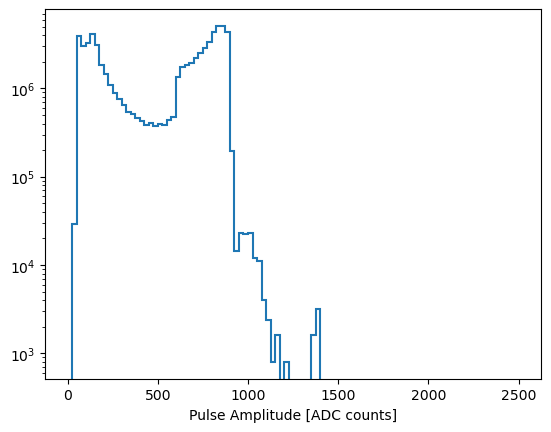

In [5]:
h.project(2).plot()
plt.yscale("log")

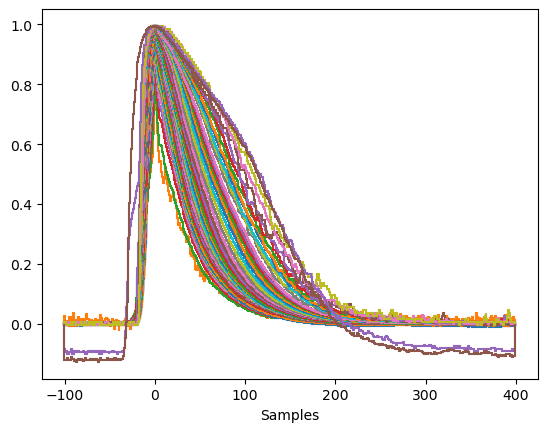

In [6]:
h[-100j:400j,...].profile(1).stack(1).plot(yerr=False)
# plt.legend()
plt.show()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fed8d906b10>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fed8f2f6410>, text=[])

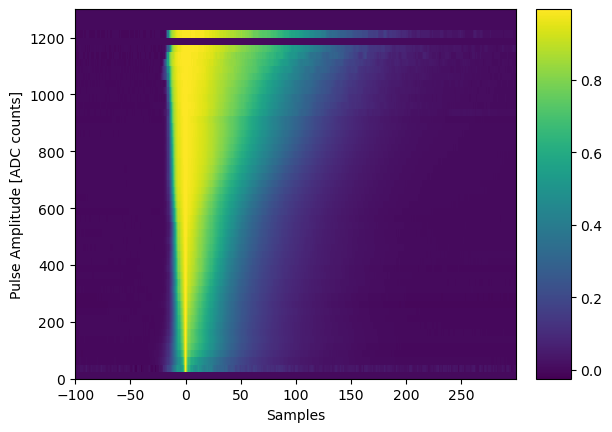

In [7]:
h2 = h.profile(1)[-100j:300j,:1300j]
h2.plot(
    # norm=matplotlib.colors
)

In [8]:
from scipy.interpolate import RegularGridInterpolator

In [9]:
xs, ys = np.meshgrid(h2.axes[0].centers, h2.axes[1].centers, indexing='ij')
zs = h2.values()

In [10]:
xs, ys

(array([[-100., -100., -100., ..., -100., -100., -100.],
        [ -99.,  -99.,  -99., ...,  -99.,  -99.,  -99.],
        [ -98.,  -98.,  -98., ...,  -98.,  -98.,  -98.],
        ...,
        [ 297.,  297.,  297., ...,  297.,  297.,  297.],
        [ 298.,  298.,  298., ...,  298.,  298.,  298.],
        [ 299.,  299.,  299., ...,  299.,  299.,  299.]]),
 array([[  12.5,   37.5,   62.5, ..., 1237.5, 1262.5, 1287.5],
        [  12.5,   37.5,   62.5, ..., 1237.5, 1262.5, 1287.5],
        [  12.5,   37.5,   62.5, ..., 1237.5, 1262.5, 1287.5],
        ...,
        [  12.5,   37.5,   62.5, ..., 1237.5, 1262.5, 1287.5],
        [  12.5,   37.5,   62.5, ..., 1237.5, 1262.5, 1287.5],
        [  12.5,   37.5,   62.5, ..., 1237.5, 1262.5, 1287.5]]))

In [11]:
xs.shape, ys.shape

((400, 52), (400, 52))

In [12]:
zs.shape

(400, 52)

In [13]:
interp = RegularGridInterpolator((h2.axes[0].centers, h2.axes[1].centers), zs, bounds_error=False, fill_value=0)
interp

In [14]:
xx = np.linspace(-200,400,1000)
yy = np.linspace(0,2000,1000)
X, Y = np.meshgrid(xx, yy, indexing='ij')
Z = interp((X,Y))

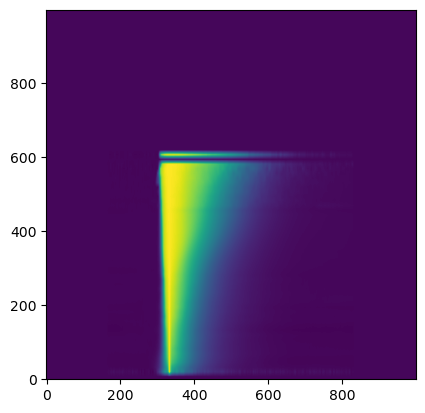

In [15]:
plt.imshow(Z.T,origin='lower')

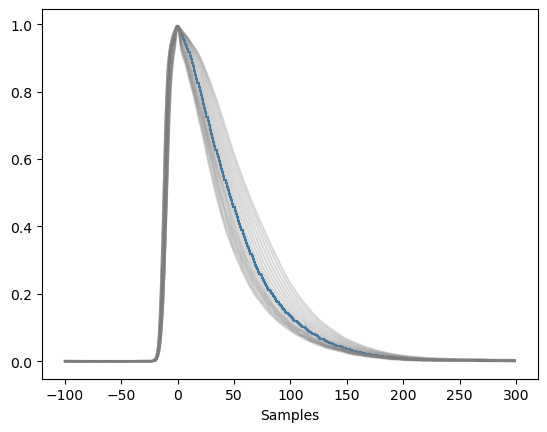

In [16]:
h2[:,600j].plot(yerr=False)
for i in range(400,800,20):
    plt.plot(h2.axes[0].centers, interp((h2.axes[0].centers,i)), color='grey',alpha=.3)
plt.show()

In [17]:
h2.axes[0].centers.size

400

In [18]:
h2[3,4].value

-0.0022941754730891766

In [19]:
def make_tgraph_from_hist(h):
    gr = r.TGraph2D(h.axes[0].centers.size * h.axes[1].centers.size)
    counter = 0
    for i,xi in enumerate(h.axes[0].centers):
        for j, yj in enumerate(h.axes[1].centers):
            gr.SetPoint(counter, xi, yj, h[i,j].value)
            counter += 1
    return gr 

gr = make_tgraph_from_hist(h2)
gr

In [20]:
c = r.TCanvas()
r.gStyle.SetPalette(1)
gr.Draw("surf1")
c.Draw()

In [21]:
def trace_to_tgraph(wf):
    gr = r.TGraph(wf.trace.size())
    for i in range(wf.trace.size()):
        gr.SetPoint(i, i, wf.trace[i])
    return gr

In [22]:
fout = r.TFile('graph.root', 'RECREATE')
gr.Write()
counter = 0
limit = 10
for i, e in enumerate(t):
    for j,wf in enumerate(e.lyso_waveforms):
        if(wf.channelTag != channel):
            continue
        counter += 1
        gri = trace_to_tgraph(wf)
        gri.Write(f'trace_{counter}')
fout.Write()
fout.Close()

In [23]:
gr.Interpolate(50,100)

0.2268812917131443

In [24]:
from g2fit.fitting import PyFit

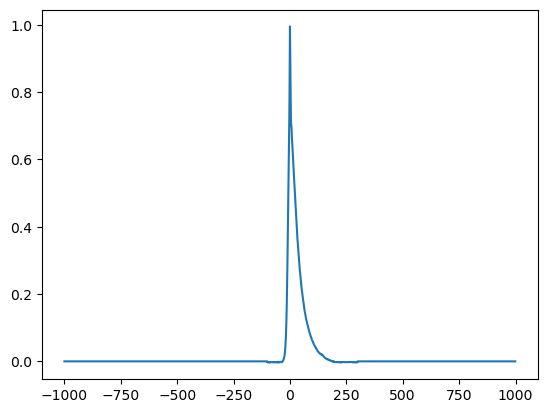

In [25]:
samples = [i for i in range(-1000,1000)]
ys = [gr.Interpolate(i,100) for i in samples]
plt.plot(samples,ys)

In [26]:
def template_2d(x,p):
    C   = p[0]
    output = np.full_like(x,C,dtype=float)
    for i in range((len(p)-1)//2):
        A   = p[i*2+1]
        x0  = p[i*2+2]
        output += A*interp((x-x0,A)) 
    return output

def do_single_fit(wf, guess):
    trace = np.array(wf.raw.GetObject().trace,dtype=float)
    samples = np.array([i for i in range(trace.size)],dtype=float)
    fiti = PyFit(samples,trace, 
                template_2d, 
                guess, 
                yerrs=np.full_like(trace,wf.pedestalStdev),
                drop_nans=True,
                # names=['C',]+[]
    )
    fiti.fit()
    return fiti

def plot_fit_and_residuals(fiti):
    fig,ax = plt.subplot_mosaic('A\nA\nA\nB',figsize=(12,7),sharex=True)
    fiti.simple_plot(ax=ax['A'])
    ax['B'].plot(fiti.xs, fiti.residuals())
    # plt.ylim(0,1000)
    # plt.show()
    return fig,ax

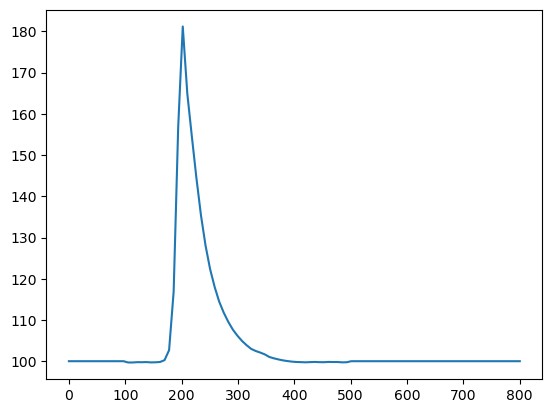

In [27]:
xs = np.linspace(0,800,100)
plt.plot(xs, template_2d(xs, [100,100,200]))

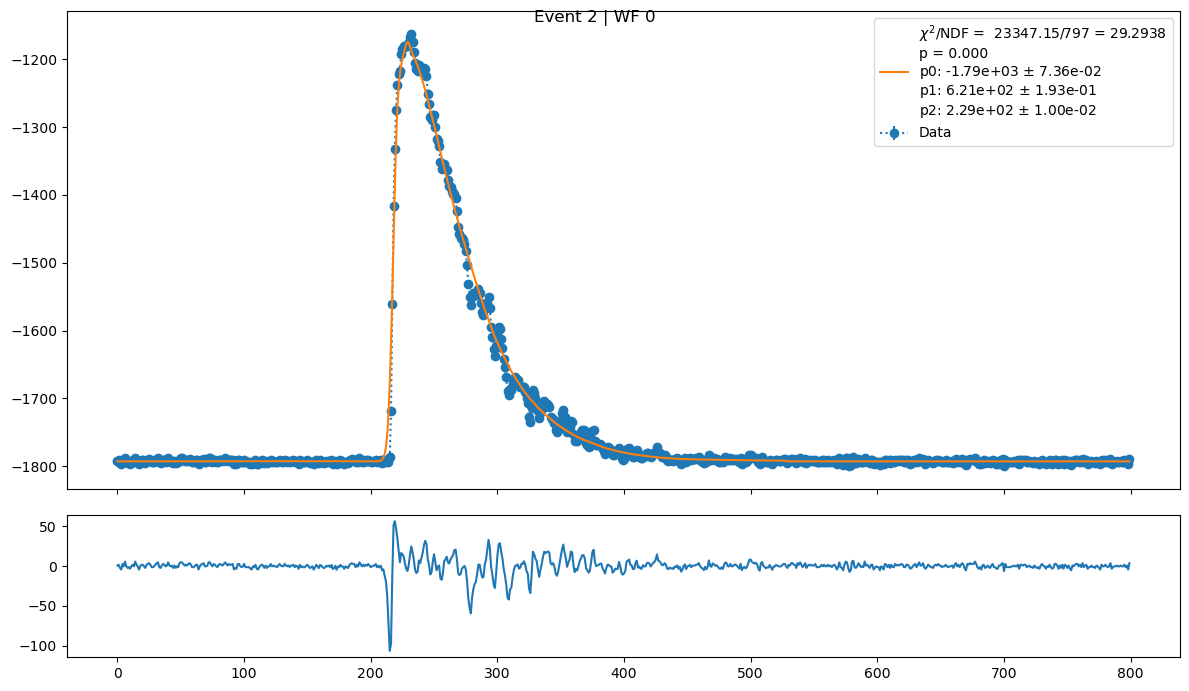

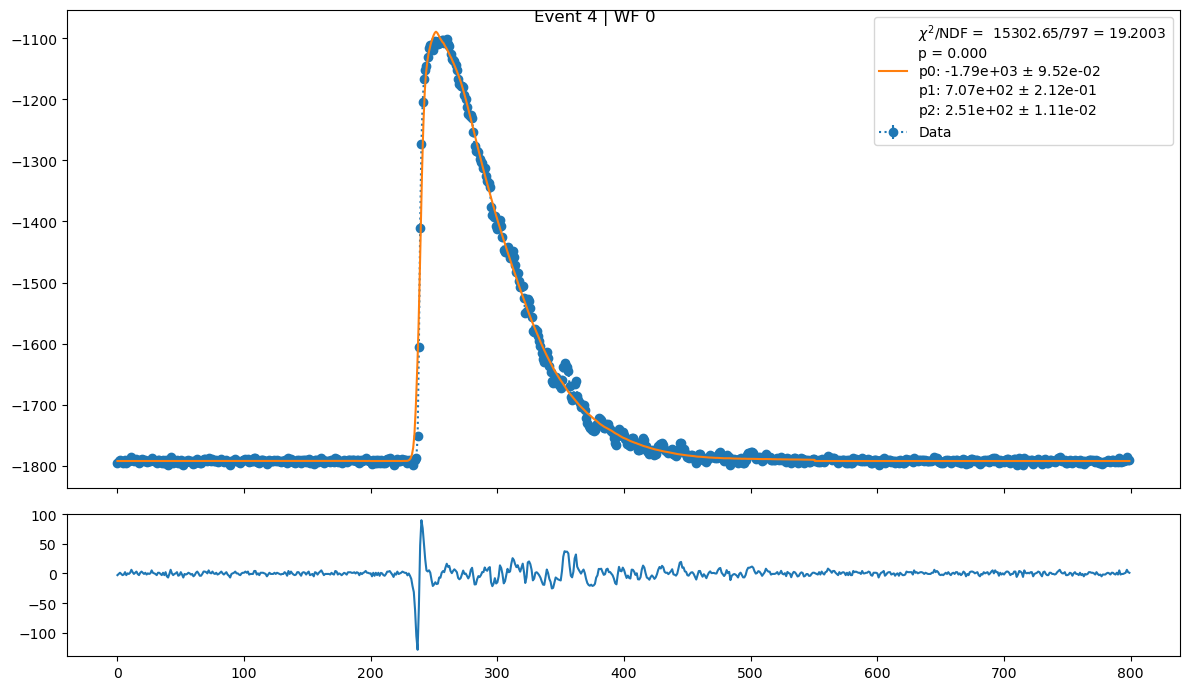

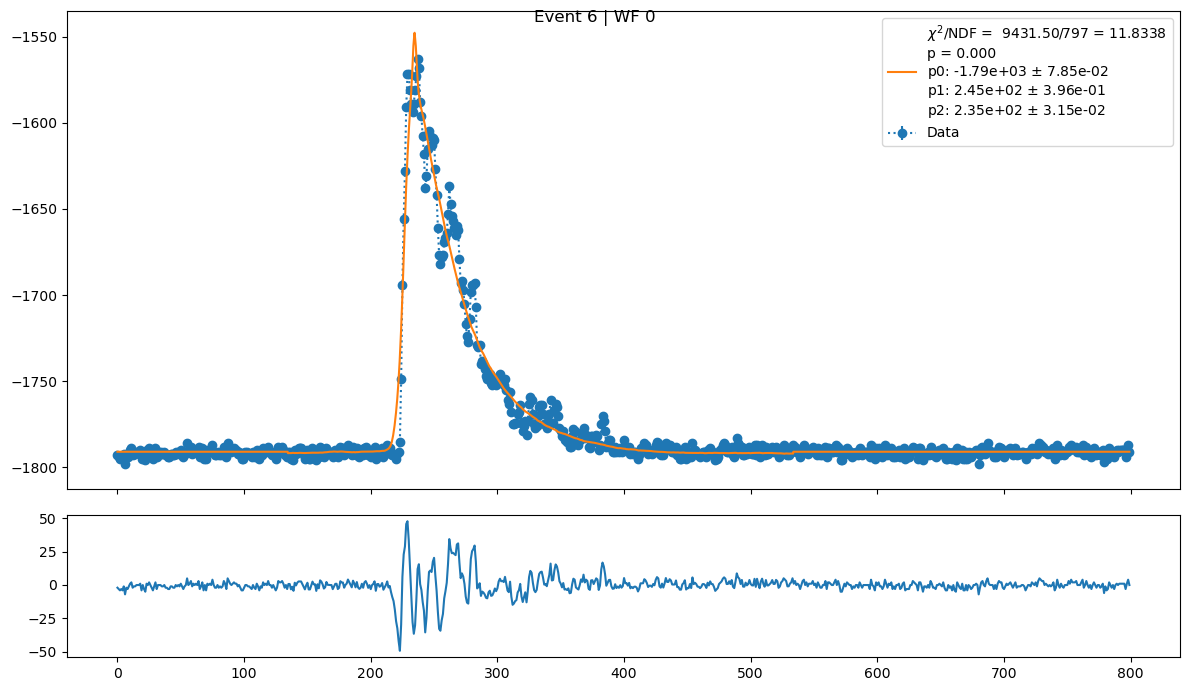

ERROR: Fit did not converge properly.


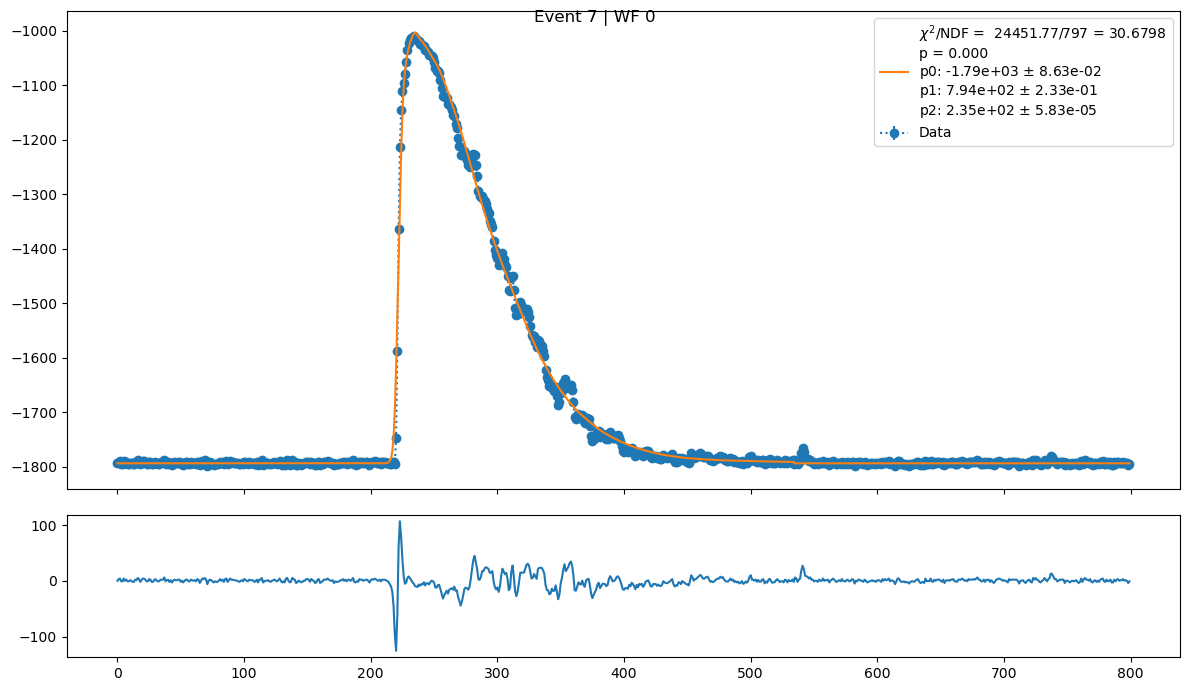

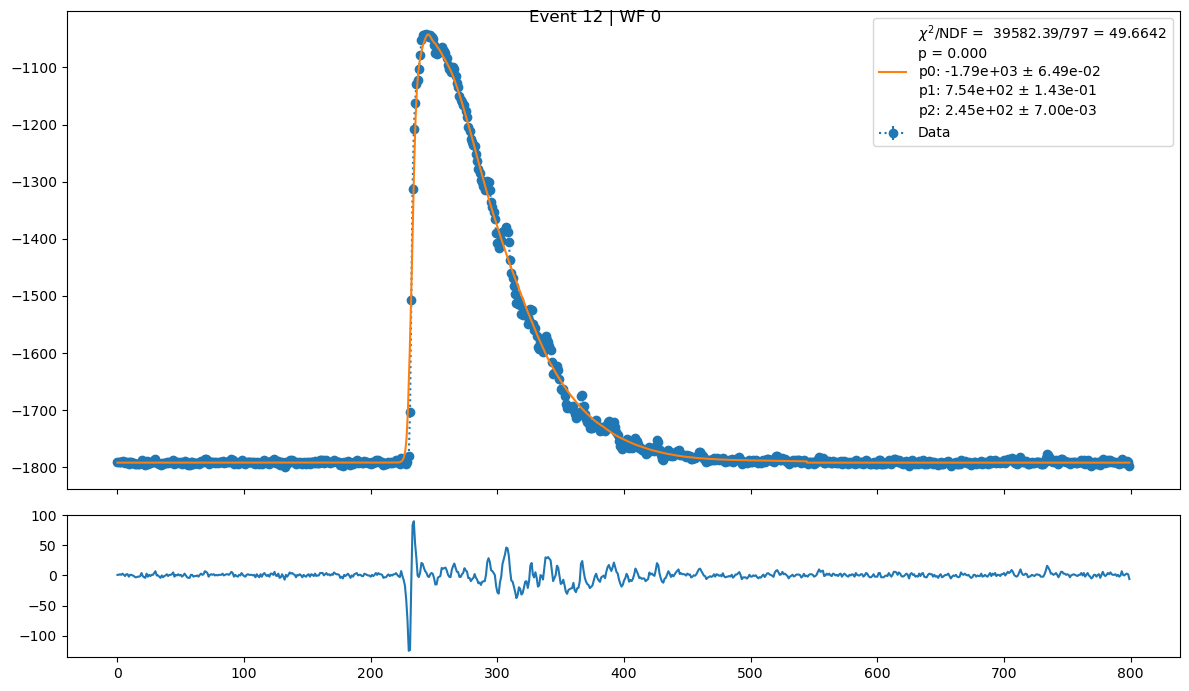

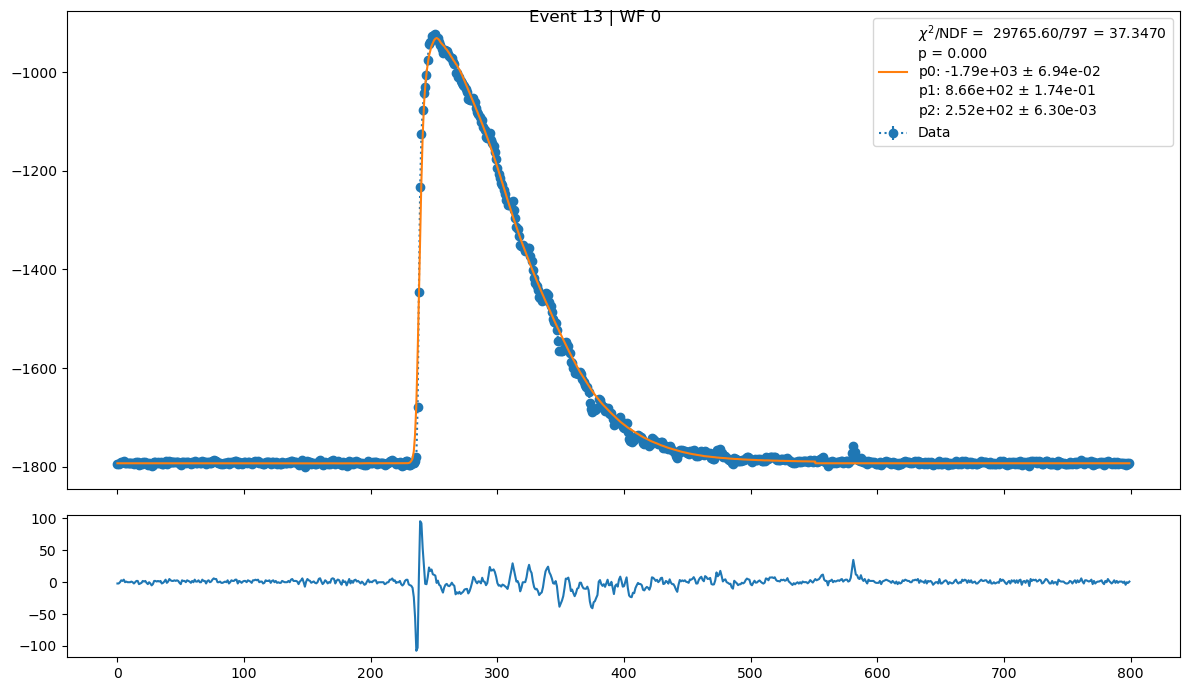

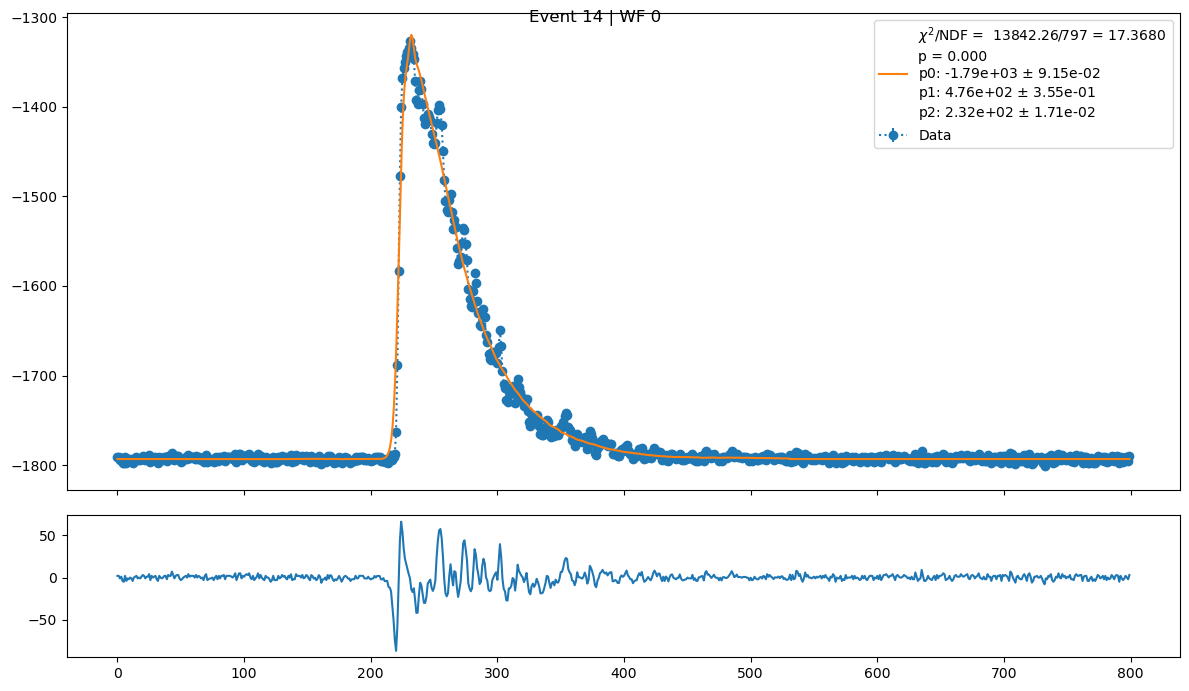

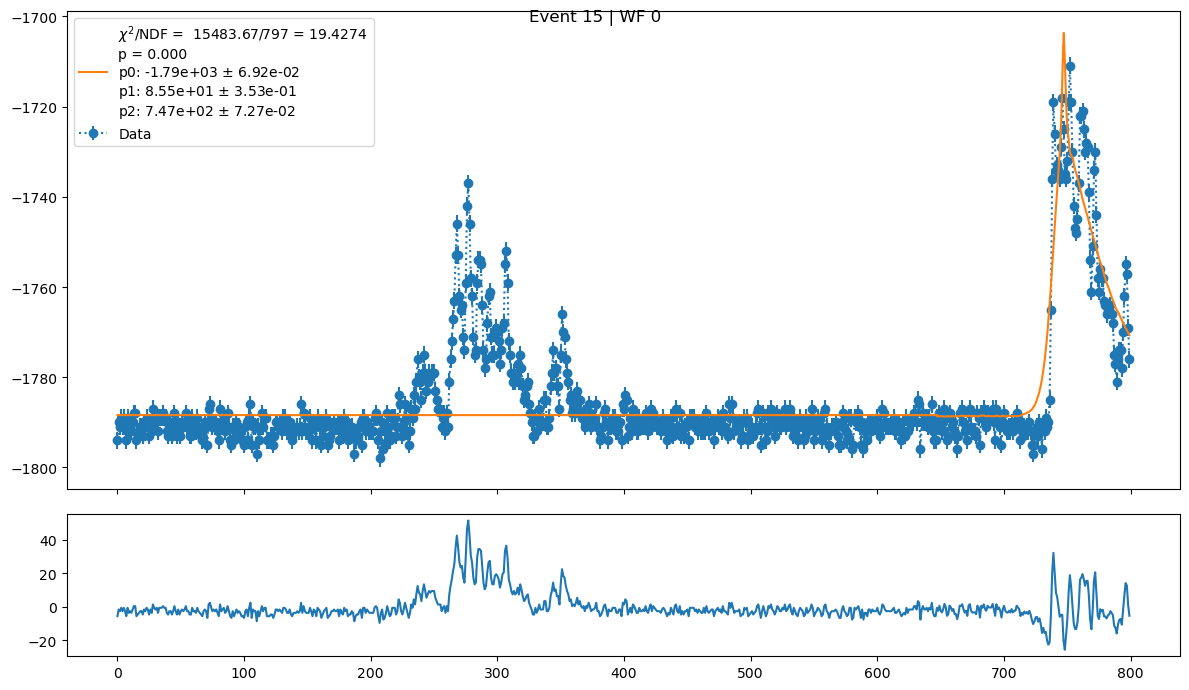

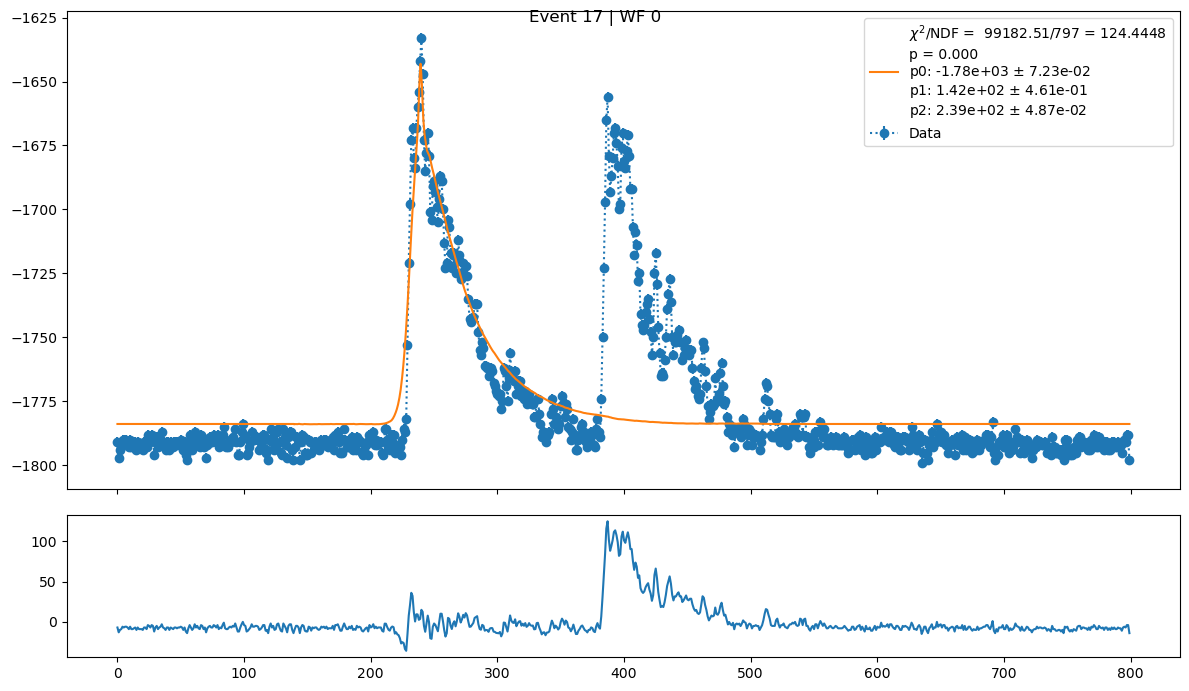

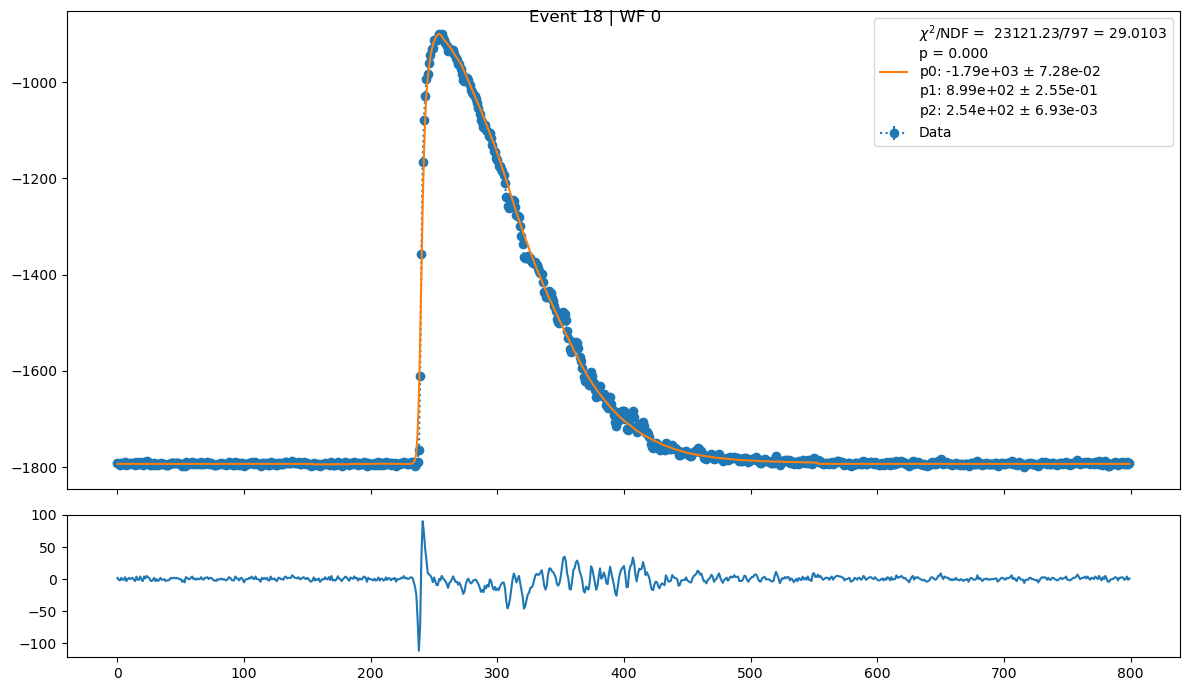

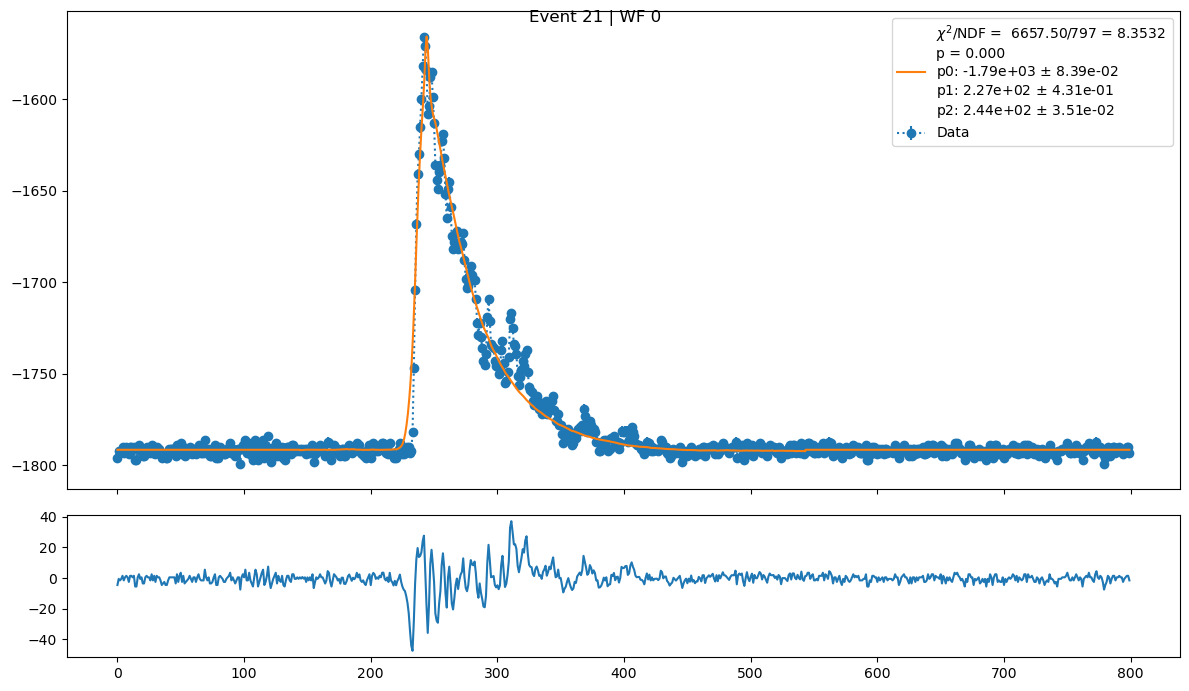

In [28]:
counter = 0
limit = 10
for i, e in enumerate(t):
    for j,wf in enumerate(e.lyso_integrals):
        if(wf.channelTag != channel):
            continue
        counter += 1
        fiti = do_single_fit(wf,guess=[wf.pedestalLevel,wf.amplitude,wf.integration_window.first])
        plot_fit_and_residuals(fiti)
        plt.suptitle(f'Event {i} | WF {j}')
        plt.show()
    if(counter > limit):
        break

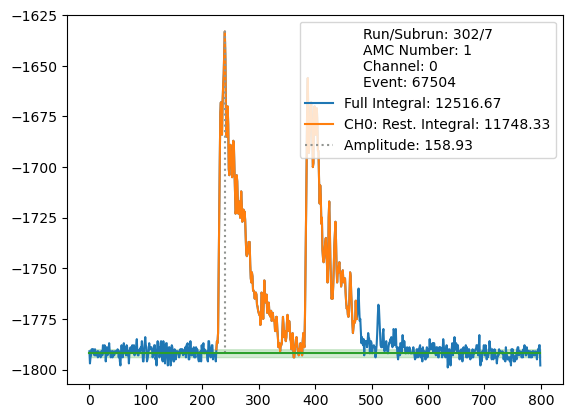

In [29]:
t.GetEntry(17)
wf = e.lyso_integrals[0]
plot_integral(wf)
plt.show()

(<Figure size 1200x700 with 2 Axes>,
 {'A': <Axes: label='A'>, 'B': <Axes: label='B'>})

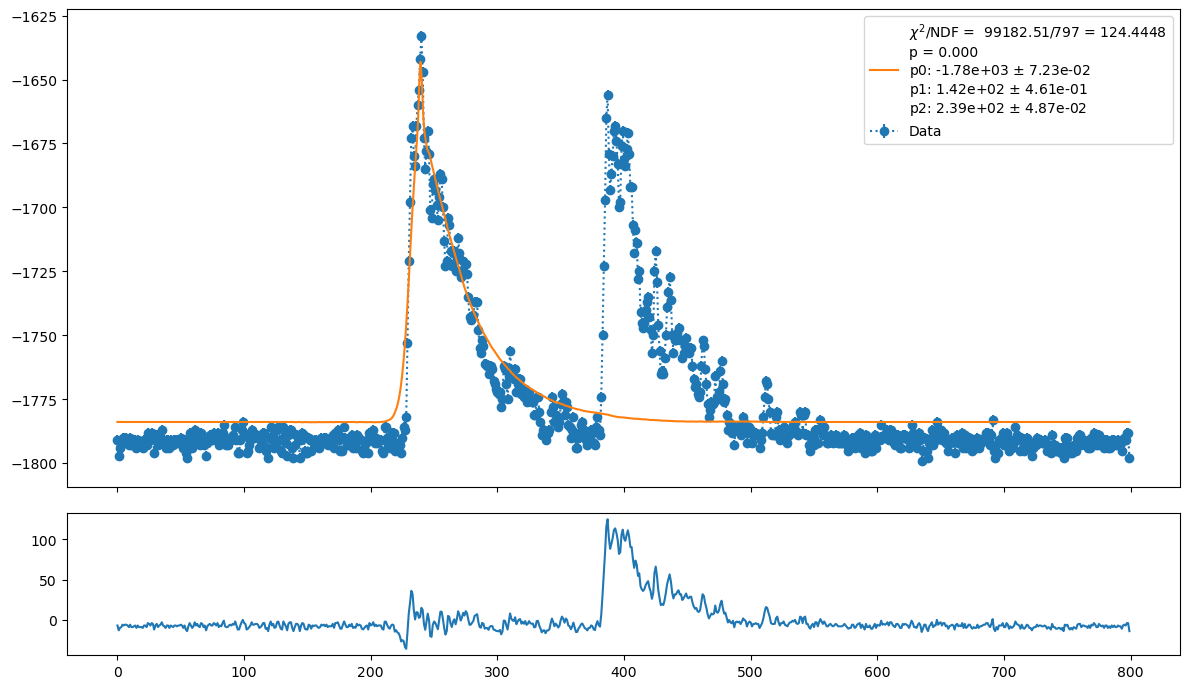

In [30]:
fiti = do_single_fit(wf,[wf.pedestalLevel, 100,200])
plot_fit_and_residuals(fiti)

(<Figure size 1200x700 with 2 Axes>,
 {'A': <Axes: label='A'>, 'B': <Axes: label='B'>})

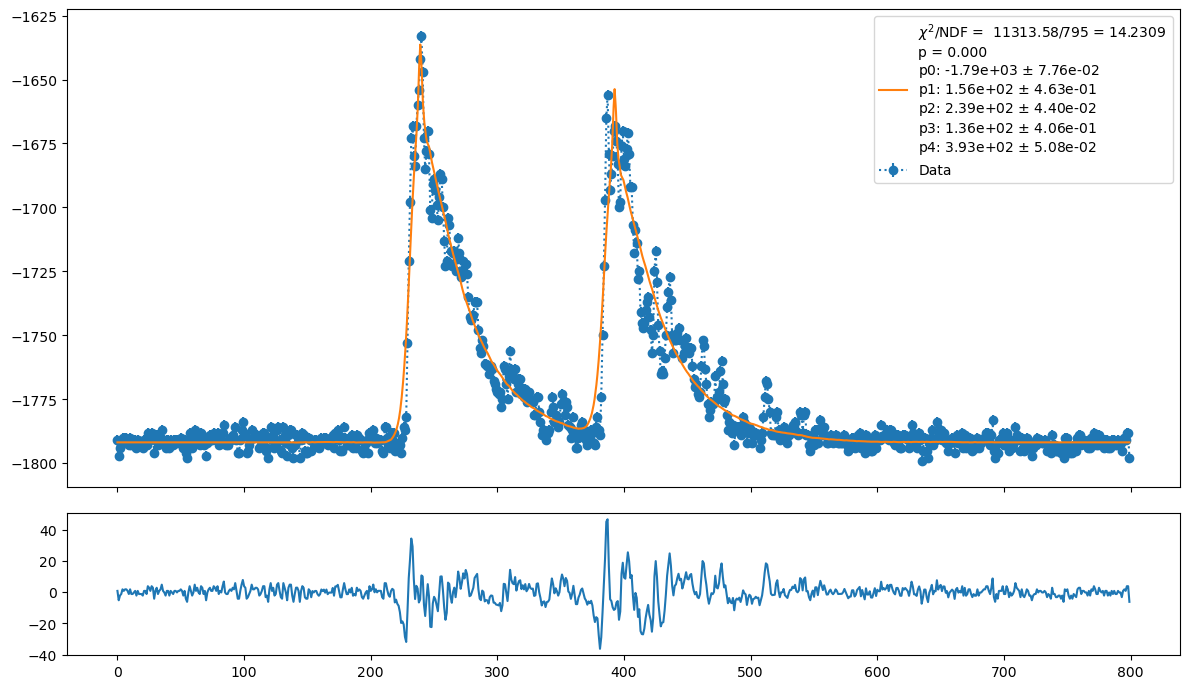

In [31]:
fiti = do_single_fit(wf,[wf.pedestalLevel, 100,200, 100, 400])
plot_fit_and_residuals(fiti)

---

In [32]:
import pickle
from iminuit import Minuit
from iminuit.cost import LeastSquares

class TemplateFit():
    #@profile   
    def __init__(self, data:np.ndarray, template:RegularGridInterpolator, chi2limit=2, 
                 scalex=True, scaley=True, verbose=True, adt=5, 
                pulse_cutoff=100, pulse_threshold=1,
                minimum_energy = 10,
                do_complex_maxima_identification=False,
                pulse_rounding = 3,
                required_template_time=100, 
                fit_limit=5) -> None:
        self.data = data 

        self.template = template
        self.current_guess = [0,0,0]
        self.chi2 = -1
        self.verbose=verbose
        self.npar = 3 # number of parameters for each iteration in the template_function function

        # if the minimum energy parameter is <= 0, then dynamically set it 
        #    based on the noise level in the sample
        # if(minimum_energy <= 0):



        #establish time limits such that the peaks can not be before the start of the data or within X ns of the end
        self.time_limits = (-1*np.amax(data[0]) + required_template_time, -1*np.amin(data[0]))
        self.pulse_rounding = pulse_rounding # where to round fit parameters when deciding whether they are equal

        self.pulse_cutoff = pulse_cutoff       # height parameter passed to scipy.find_peaks
        self.pulse_threshold = pulse_threshold # threshold parameter passed to scipy.find_peaks
        self.do_complex_maxima_identification = do_complex_maxima_identification #whether to find initial peak(s) using peak fit or simple maximum

        self.minimum_energy = minimum_energy # minimum pulse height of a pulse to fit
        self.fit_limit = fit_limit      # number of fits which can be simultainiously performed
        #TODO: Implement ADT enforcement (will need to think about how to do this for n>2 pulses)
        self.adt = adt                  # artificial dead time, below which two pulses can not be resolved
        self.chi2limit = chi2limit      # limit below which we say a fit has converged
        self.scalex = scalex            # whether we can scale the template amplitude to make the fit converge better
        self.scaley = scaley            # whether we can stretch/compress the template to make the fit better.
        self.convergencelimit = 10      # number of iterations to try before giving up

    def save(self, outfile):
        '''
            Saves the template fit to an output file
        '''
        with open(outfile, 'wb') as fout:
            pickle.dump(self, fout)
        print("Template written to:", outfile)

    def trim_zeros(self):
        mask = np.where(self.data[1] == 0, False, True)
        # print(mask)
        mask = np.nonzero(mask)[0]
        min_element = mask[0]
        max_element = mask[-1]
        # print(min_element, max_element)

        self.data = (self.data[0][min_element:max_element],
                    self.data[1][min_element:max_element])

        

    def template_function(self, x:np.ndarray, p:np.ndarray):
        '''
            Uses self.template to form a function which can be used by the iMinuit least squares fitter
            Takes in a variable number of parameters, which will be used to determine how many time/amplitude 
            shifted versions of the template to apply.

            Returns: combined template evaluated at the parameters
        '''

        nparams = self.npar
        number_of_fits = int(len(p) / nparams)
        assert len(p) % nparams == 0, ValueError()

        pedestal = p[1] #hijack the first 'stretch' for the pedestal

        ys = np.zeros_like(x) + pedestal
        for i in range(number_of_fits):
            amplitude_factor = p[i*nparams + 0]
            stretch_factor   = p[i*nparams + 1]
            time_offset      = p[i*nparams + 2]

            ys += amplitude_factor * self.template( (x + time_offset, amplitude_factor) )

        return ys

    #@profile
    def do_single_fit(self,xs,ys,param_guess):
        yerrs = np.ones_like(xs)
        minimizer = LeastSquares( xs, ys, yerrs, self.template_function  )
        m = Minuit(minimizer, param_guess )  # starting values for minimization
        # m.strategy = 0
        # m.limits[0]

        nparams = self.npar
        number_of_fits = int(len(param_guess) / nparams)
        assert len(param_guess) % nparams == 0, ValueError()

        for i in range(number_of_fits):
            m.limits[i*nparams    ] = (self.minimum_energy, None)   # limit on pulse height 
            if(i > 0):
                m.fixed[i*nparams + 1 ] = True                          # limit on pulse template stretching
            m.limits[i*nparams + 2] = self.time_limits              # limit on pulse time

        m.migrad()  # finds minimum of least_squares function
        m.hesse()   # accurately computes uncertainties
        # m.minos()

        # print(m)
        return m

    #@profile
    def identify_local_maxima(self, data):
        '''
            Function to pull out the initial conditions for a LXe pulse fit. 
            Identifies local maxima and tags them.
        '''
        maxima = []
        times = []

        from scipy.signal import find_peaks
        # for local maxima
        peaks, _ = find_peaks(data[1],
                              height=self.pulse_cutoff, 
                              threshold=self.pulse_threshold, 
                              width=self.adt) #TODO: Make the height parameter vary based on noise in pulse
        for x in peaks:
            maxima.append(data[1][x]*1.2)
            times.append(data[0][x])

        return maxima, times

    def identify_new_peak(self, xs, residuals, guess):
        '''
            Identifies the next peak to be fit based on the residuals of the current fit
        '''
        # mask the residuals based on the current peaks and the ADT
        residuals = np.copy(residuals) # make a copy so we don't disrupt the original
        current_peaks = [-1.0*guess[i*self.npar+2] for i in range(int(len(guess)/self.npar))]
        if(self.verbose):
            print("Masking based on:", current_peaks)

        for i, xi in enumerate(xs):
            for peak in current_peaks:
                if(xi >= peak - self.adt and xi <= peak + self.adt):
                    residuals[i] = 0

        # identify the peaks in the masked residuals
        new_maximum = np.amax( residuals )
        maximum_time = self.intermediate_xs[ np.where( residuals == new_maximum )[0] ][0]

        return new_maximum, maximum_time

    def peaks_too_close(self, new, guess):
        '''
            Returns true if the new peak is too close to any of the existing peaks
        '''
        current_peaks = [-1.0*guess[i*self.npar+2] for i in range(int(len(guess)/self.npar))]
        if(self.verbose):
            print("Masking based on:", current_peaks)

        xi = new[-1]*-1.0
        for peak in current_peaks:
            if(xi >= peak - self.adt and xi <= peak + self.adt):
                return True
        
        return False

    def times(self):
        '''
            Returns the current peak times
        '''
        nparams = self.npar
        number_of_fits = int(len(self.current_guess) / nparams)
        assert len(self.current_guess) % nparams == 0, ValueError()

        return [self.current_guess[i*nparams + 2] for i in range(number_of_fits)]

    def energies(self):
        nparams = self.npar
        number_of_fits = int(len(self.current_guess) / nparams)
        assert len(self.current_guess) % nparams == 0, ValueError()

        return [self.current_guess[i*nparams] for i in range(number_of_fits)]

    def times_err(self):
        '''
            Returns the current peak times
        '''
        nparams = self.npar
        number_of_fits = int(len(self.current_guess) / nparams)
        assert len(self.current_guess) % nparams == 0, ValueError()

        return [self.m.errors[i*nparams + 2] for i in range(number_of_fits)]

    def energies_err(self):
        nparams = self.npar
        number_of_fits = int(len(self.current_guess) / nparams)
        assert len(self.current_guess) % nparams == 0, ValueError()

        return [self.m.errors[i*nparams] for i in range(number_of_fits)]


    #@profile
    def do_fit(self):  # sourcery no-metrics
        self.chi2 = 1e12
        self.niterations = 0
        self.npulses = 1

        self.intermediate_xs = self.data[0]
        self.intermediate_ys = self.data[1]

        if(self.do_complex_maxima_identification):
            maxima, times = self.identify_local_maxima(self.data)
        else:
            maxima, times = [], []

        if(len(maxima) < 2):
            # self.current_guess = [1,0,0]
            new_maximum = np.amax( self.intermediate_ys )
            maximum_time = self.intermediate_xs[ np.where( self.intermediate_ys  == new_maximum )[0] ][0]
            self.current_guess = [new_maximum,0, -1.0*maximum_time]
        else:
            # raise NotImplementedError
            self.npulses = len(maxima)
            self.current_guess = []
            for time, maxi in zip(times,maxima):
                self.current_guess += [maxi, 0, -time]

        while(True):
            if(self.verbose):
                print("**********************************************************************************")
                print("Fitting with Current guess:", self.current_guess)
                # print(new_maximum, maximum_time)
            self.niterations += 1
            if(self.niterations > self.convergencelimit):
                print(f"Warning: Fit did not converge in {self.convergencelimit} iterations")
                break
                # raise TimeoutError(f"Error: Fit did not converge in {self.convergencelimit} iterations")

            m = self.do_single_fit(self.intermediate_xs, self.intermediate_ys, self.current_guess)
            if(self.verbose):
                print('Fit valid:', m.valid)
                print('Fit params:', m.values)
                print("Fit chi2:", m.fmin.reduced_chi2)
            # input("so?")

            self.current_guess = list(m.values)
            self.chi2 = m.fmin.reduced_chi2
            self.m = m

            # if(self.chi2 < self.chi2limit):
            #     break

            if(self.verbose):
                fig,ax = plt.subplots(figsize=(15,5))
                plt.plot(self.intermediate_ys , label="Data")
                plt.plot( self.template_function(self.intermediate_xs, self.current_guess), label="Fit (before additional)")
                plt.legend()
                plt.yscale("symlog")
                plt.grid()
                plt.show()


            # remove pulses in this combined fit for which the amplitude/time is at the limit
            # TODO: Test/refine this portion of the logic
            if(self.verbose > 0):
                print("Removing extraneus pulses at limit")
            found_pulse_at_limit = False
            for i in range(int(len(self.current_guess)/self.npar)):
                if(
                    round(m.values[(i+1)*self.npar-3],self.pulse_rounding) == round(m.limits[(i+1)*self.npar-3][0],self.pulse_rounding) or 
                    round(m.values[(i+1)*self.npar-1],self.pulse_rounding) == round(m.limits[(i+1)*self.npar-1][0],self.pulse_rounding)
                ):
                    if(self.verbose > 0):
                        print("Found intermediate pulse at limit, removing from fit")
                        print('   -> Before', self.current_guess)
                    self.current_guess = self.current_guess[:i*self.npar] + self.current_guess[i*self.npar + 3:]
                    if(self.verbose > 0):
                        print('   -> After', self.current_guess)
                    self.npulses -= 1
                    found_pulse_at_limit = True

            if(len(self.current_guess) == 0):
                if(self.verbose > 0):
                    print("No fittable pulses found above limit!")
                break

            if(found_pulse_at_limit):
                continue



            # try adding another pulse to the mix, and see if that reduces the chi2
            # print( self.intermediate_ys , self.template_function(self.intermediate_xs, self.current_guess) )
            residuals = self.intermediate_ys - self.template_function(self.intermediate_xs, self.current_guess)
            new_maximum, maximum_time = self.identify_new_peak(self.intermediate_xs, residuals, 
                                                               self.current_guess)

            if(self.verbose):
                print(new_maximum, maximum_time)

            
            # m2 = self.do_single_fit(self.intermediate_xs, residuals, [new_maximum, 0, -1.0*maximum_time])
            m2 = self.do_single_fit(self.intermediate_xs, self.intermediate_ys, self.current_guess+[new_maximum, 0, -1.0*maximum_time])
            if(self.verbose):
                print('   -> Residual Fit valid:', m2.valid)
                print('   -> Residual Fit params:', m2.values)
                print("   -> Residual Fit chi2:", m2.fmin.reduced_chi2)
                # input("so?")
                fig,ax = plt.subplots(figsize=(15,5))
                plt.plot(self.intermediate_xs, self.intermediate_ys, label="Data")
                plt.plot(self.intermediate_xs, residuals, label="Residuals")
                plt.plot(self.intermediate_xs, self.template_function(self.intermediate_xs, [new_maximum,0, -1.0*maximum_time]), label="New Guess")
                plt.plot(self.intermediate_xs, self.template_function(self.intermediate_xs, list(m2.values)), label="New Fit")
                plt.legend()
                plt.grid()
                plt.yscale("symlog")
                plt.show()



            if(self.npulses >= self.fit_limit):
                if(self.verbose):
                    print(f"Warning: Fit has reached the limit of allowable pulses ({self.fit_limit})")
                break
            elif( self.peaks_too_close( m2.values, self.current_guess ) ):
                if(self.verbose):
                    print(f"Warning: This peak was too close to an existing peak. Terminating fit.")
                break
            elif( round(m2.values[-3],self.pulse_rounding) == round(m2.limits[-3][0],self.pulse_rounding)):
                if(self.verbose):
                    print("Warning: rejecting this pulse because the amplitude parameter is at the limit")
                break
            elif( round(m2.values[-1],self.pulse_rounding) == round(m2.limits[-1][0],self.pulse_rounding)):
                if(self.verbose):
                    print("Warning: rejecting this pulse because the time parameter is at the limit")
                break
            elif(m2.fmin.reduced_chi2 < m.fmin.reduced_chi2):
                self.current_guess += list(m2.values[-3:])
                self.npulses += 1
            else:
                if(self.verbose > 0):
                    print(f"Fit converged with {self.npulses} simultainious fits")
                break
                # pass
            
            # break

    def plot(self, resid_scale="symlog", axi=None,legend=False):
        '''
            Plots the current fit iteration
        '''
        if(axi is None):
            # fig, axs = plt.subplots(2,1,figsize=(15,8), sharex=True)
            fig, axs = plt.subplot_mosaic('''
                0000
                0000
                1111
                ''', figsize=(15,8))
            print(axs)
            axs = [axs['0'], axs['1']]
            ax = axs[0]
        else:
            fig=None
            ax = axi
            axs = [axi]
        # plt.sca(ax)
        ax.plot(*self.data, label='Data')
        xs = np.linspace(np.amin(self.data[0]), np.amax(self.data[0]), 1000)

        param_string = ''
        ylim = ax.get_ylim()
        for i in range(int(len(self.current_guess)/self.npar)):
            if(self.verbose):
                print(i, self.current_guess[i*self.npar:i*self.npar+self.npar])
            param_string += f'\nTemplate {i} with Parameters: {[round(x,self.pulse_rounding) for x in self.current_guess[i*self.npar:i*self.npar+self.npar]]}'
            ax.plot([-self.current_guess[i*self.npar+2],-self.current_guess[i*self.npar+2]], ylim, "r:")
            ax.plot(xs, self.template_function(xs, self.current_guess[i*self.npar:i*self.npar+self.npar]), color="xkcd:grey")

        param_string += f"\nchi2 = {self.chi2}"

        ax.plot(xs, self.template_function(xs, self.current_guess), label="Fit"+param_string)

        ax.set_ylim(*ylim)

        ax.grid()

        if(legend or axi is None):
            ax.legend()


        if(axi is None):
            plt.sca(axs[0])
    
            plt.sca(axs[1])
            axs[0].sharex(axs[1])
            residuals = self.data[1] - self.template_function(self.data[0], self.current_guess)
            plt.plot(self.data[0], residuals)
            plt.yscale(resid_scale)
            plt.grid()


            plt.tight_layout()

        return fig,axs


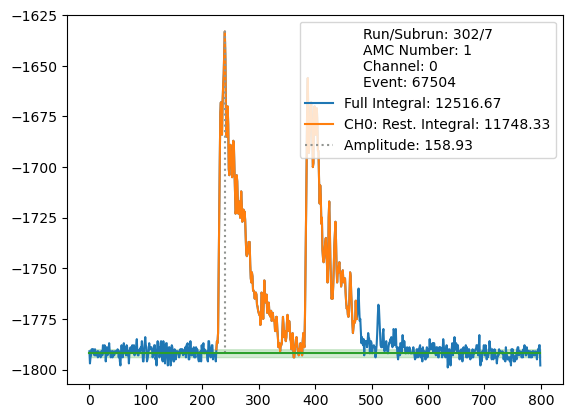

In [33]:
t.GetEntry(17)
wf = e.lyso_integrals[0]
plot_integral(wf)
plt.show()

**********************************************************************************
Fitting with Current guess: [158.9333333333334, 0, -240.0]
Fit valid: True
Fit params: <ValueView x0=142.1030265956307 x1=8.07979218039332 x2=-239.3345017333822>
Fit chi2: 470.5198656590299


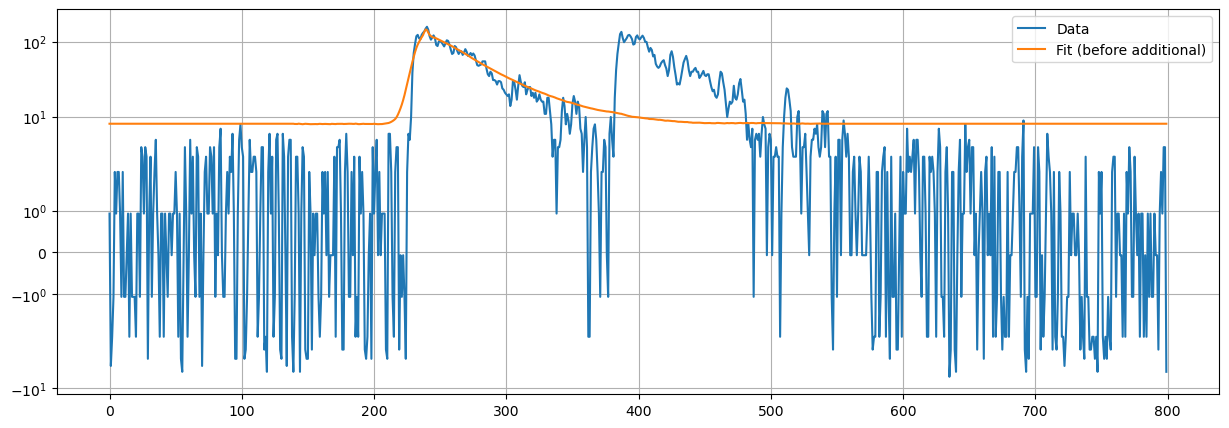

Removing extraneus pulses at limit
Masking based on: [239.3345017333822]
124.96697384499589 387.0
   -> Residual Fit valid: True
   -> Residual Fit params: <ValueView x0=156.34776497657015 x1=0.12039828310194735 x2=-239.11737240344786 x3=136.43143935141228 x4=0.0 x5=-392.5558074108407>
   -> Residual Fit chi2: 53.806419926751076


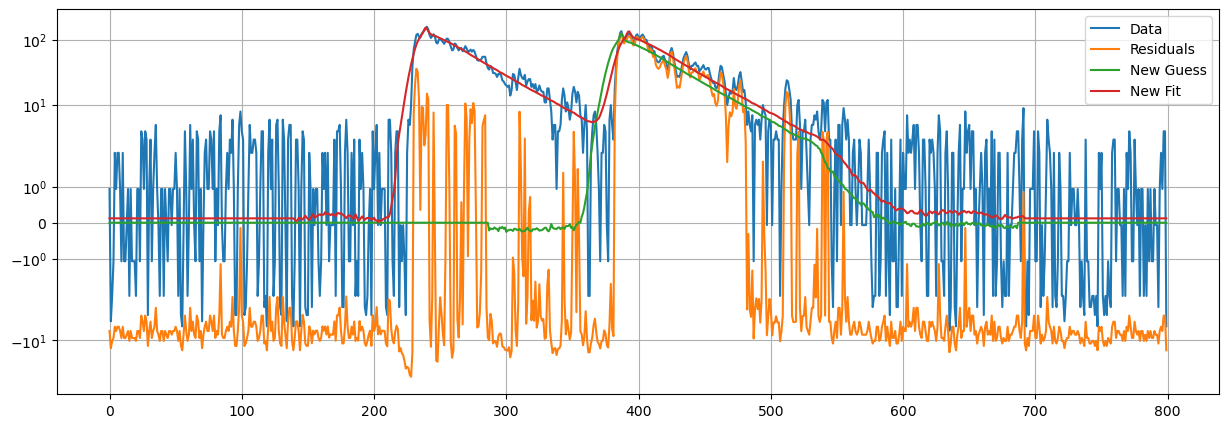

Masking based on: [239.3345017333822]
**********************************************************************************
Fitting with Current guess: [142.1030265956307, 8.07979218039332, -239.3345017333822, 136.43143935141228, 0.0, -392.5558074108407]
Fit valid: True
Fit params: <ValueView x0=156.34720964157594 x1=0.12044167841876302 x2=-239.11739275175427 x3=136.4309535576248 x4=0.0 x5=-392.55584642426805>
Fit chi2: 53.80641991704124


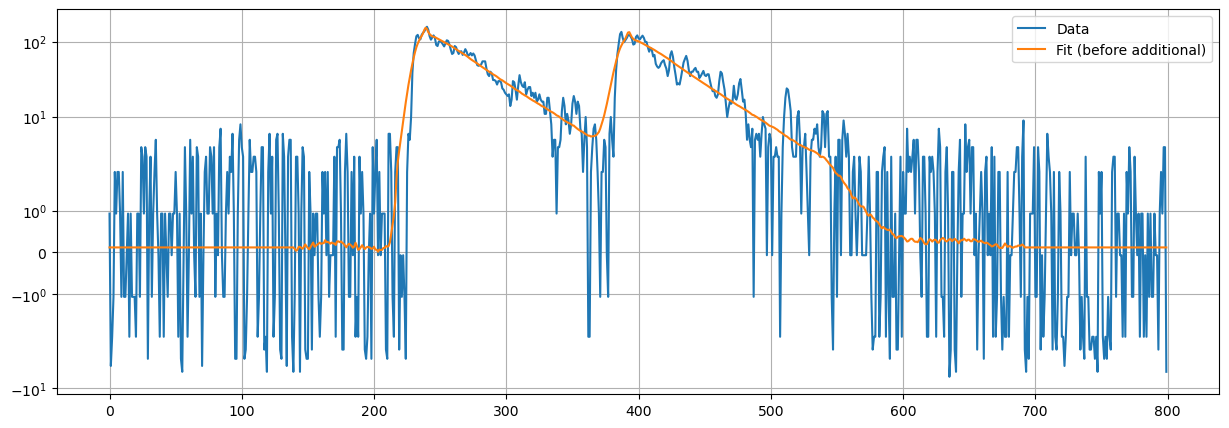

Removing extraneus pulses at limit
Masking based on: [239.11739275175427, 392.55584642426805]
46.65021443767566 387.0
   -> Residual Fit valid: True
   -> Residual Fit params: <ValueView x0=156.5899098693815 x1=-0.06141093786490419 x2=-239.1104710477757 x3=122.90855592274828 x4=0.0 x5=-393.1778092642792 x6=30.000000000000007 x7=0.0 x8=-387.0000486893562>
   -> Residual Fit chi2: 55.52461901685661


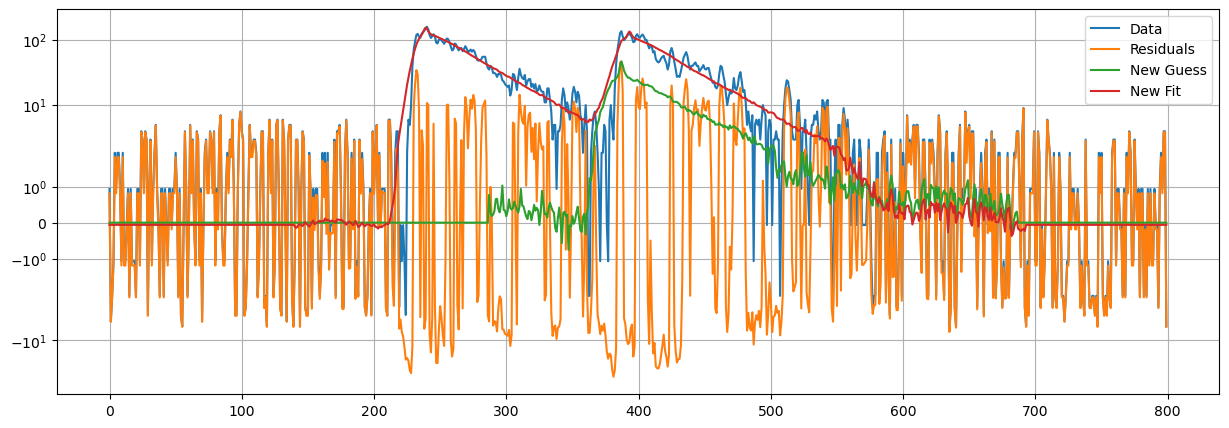

Masking based on: [239.11739275175427, 392.55584642426805]
{'0': <Axes: label='0'>, '1': <Axes: label='1'>}
0 [156.34720964157594, 0.12044167841876302, -239.11739275175427]
1 [136.4309535576248, 0.0, -392.55584642426805]


(<Figure size 1500x800 with 2 Axes>, [<Axes: label='0'>, <Axes: label='1'>])

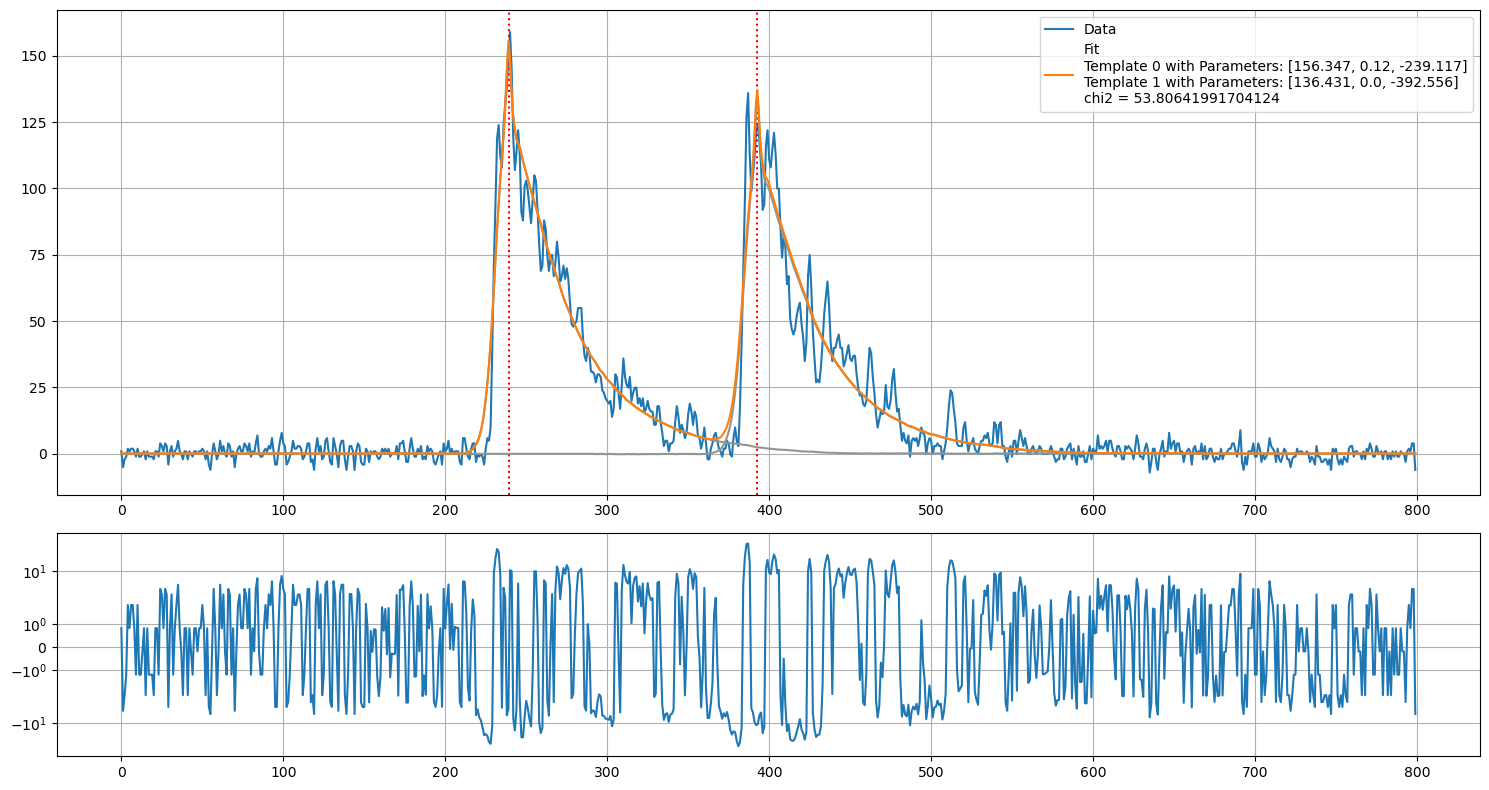

In [34]:
trace = np.array(wf.raw.GetObject().trace,float) - wf.pedestalLevel
samples = [i for i in range(len(trace))]
data = np.array((samples,trace))
fiti = TemplateFit(data, interp, minimum_energy=30)
fiti.do_fit()
fiti.plot()

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


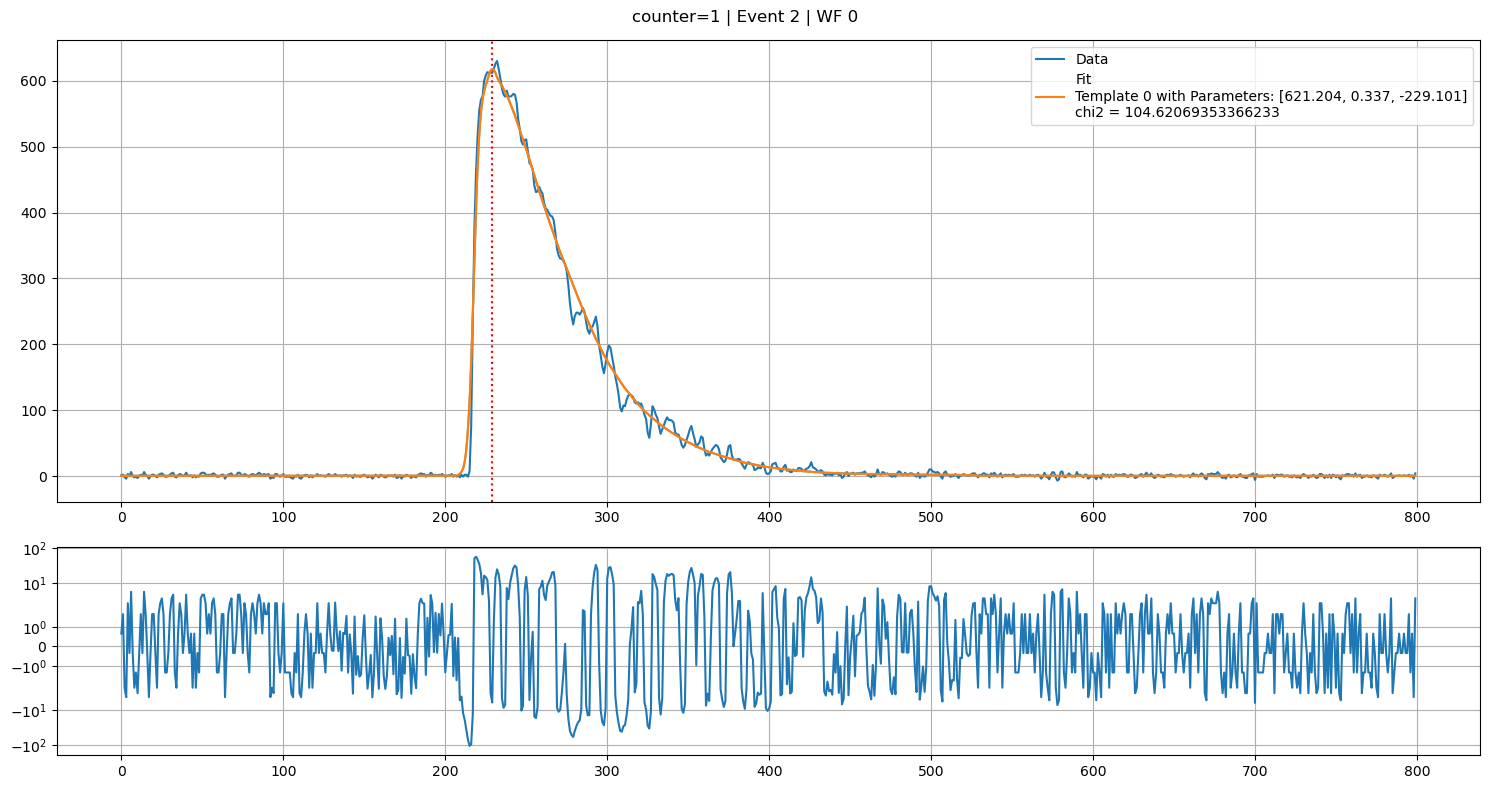

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


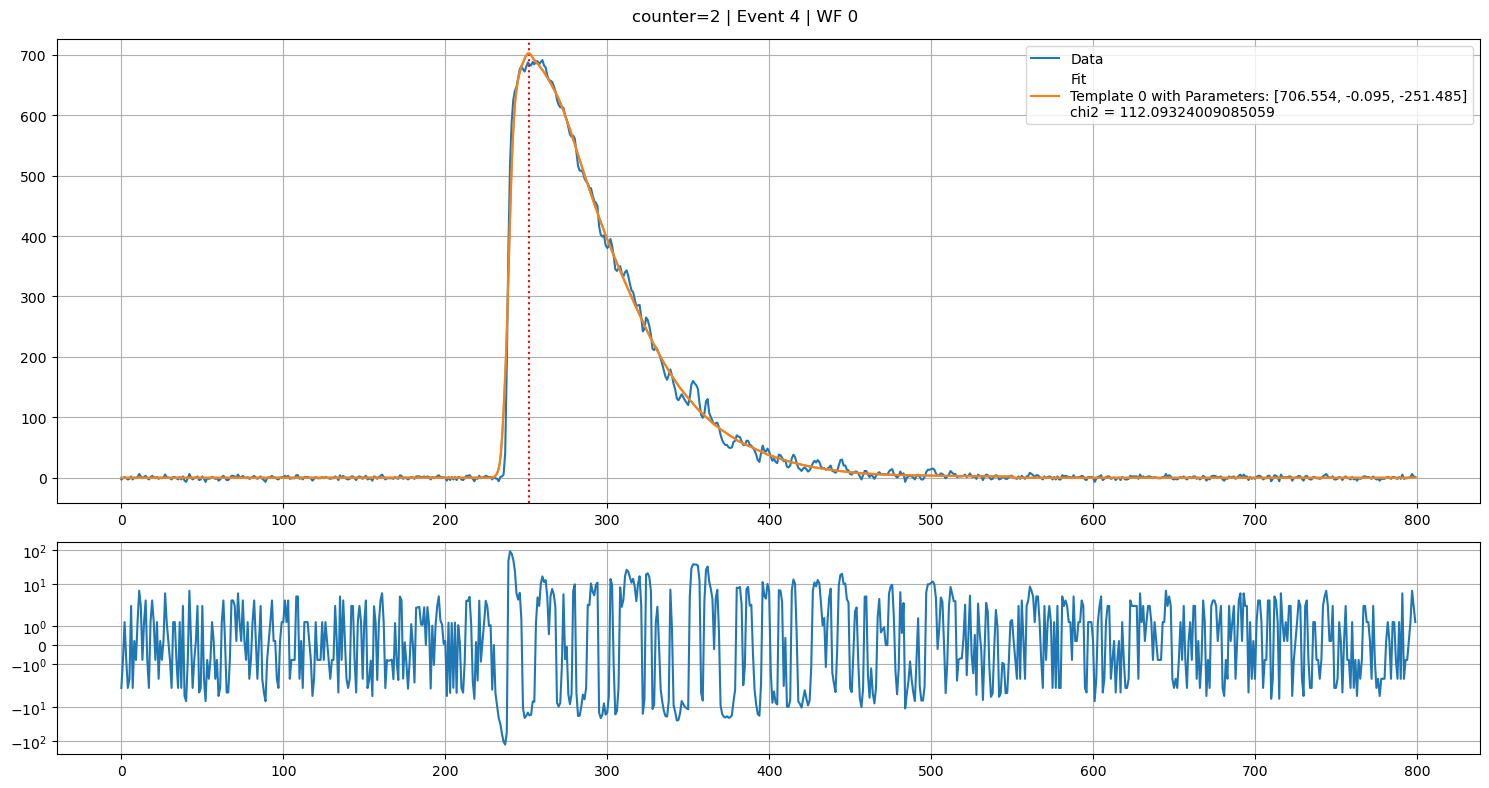

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


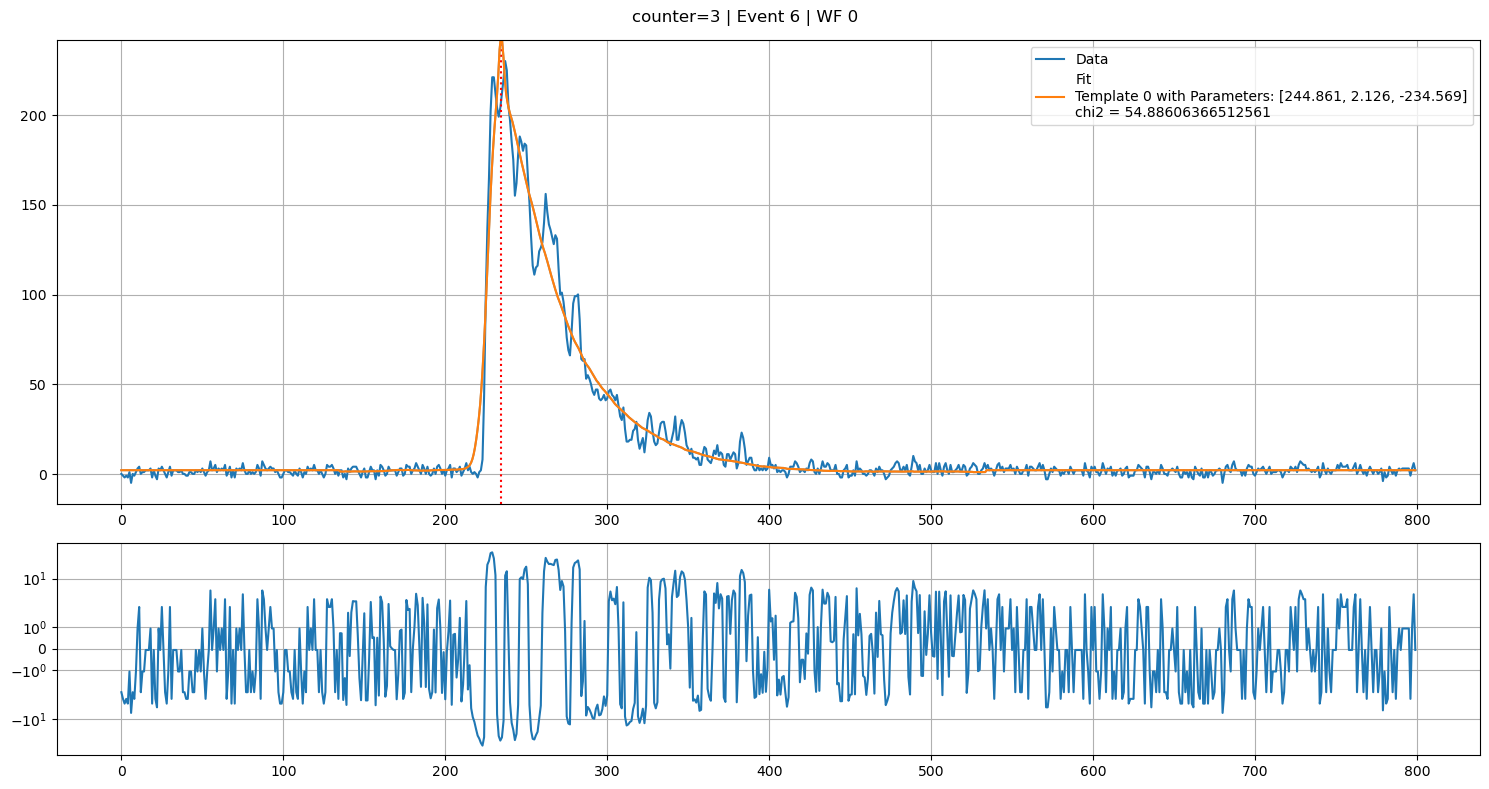

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


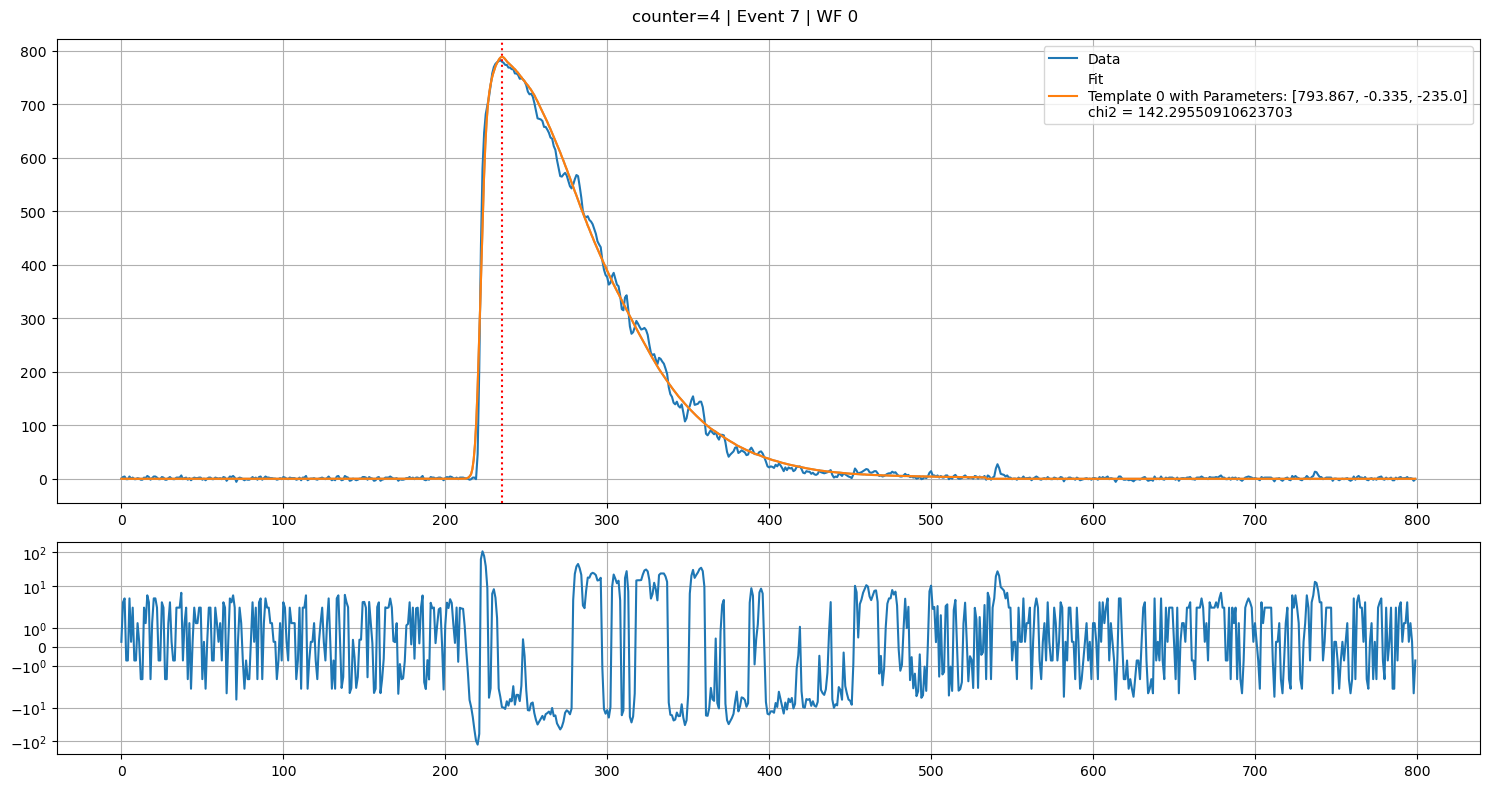

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


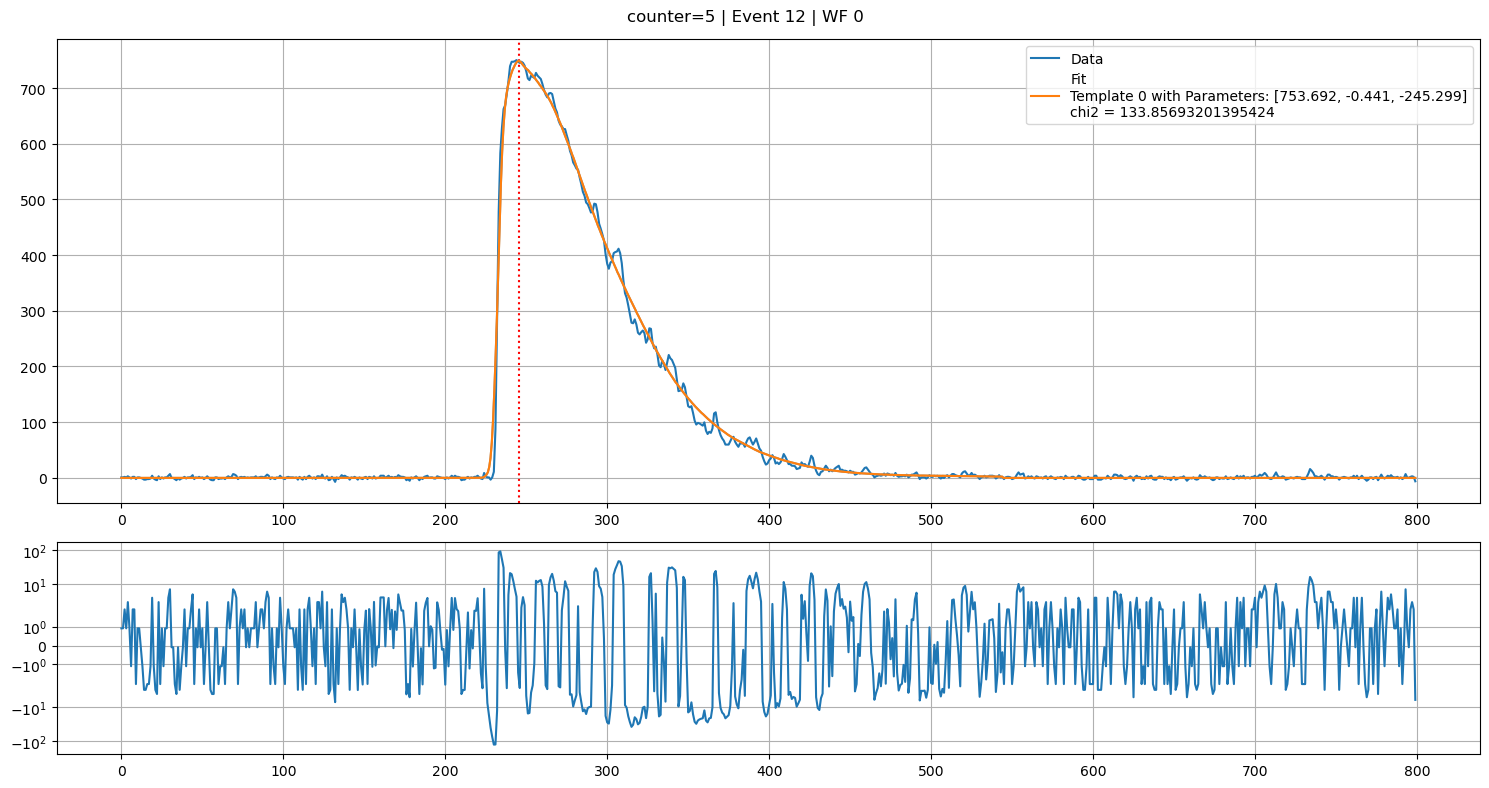

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


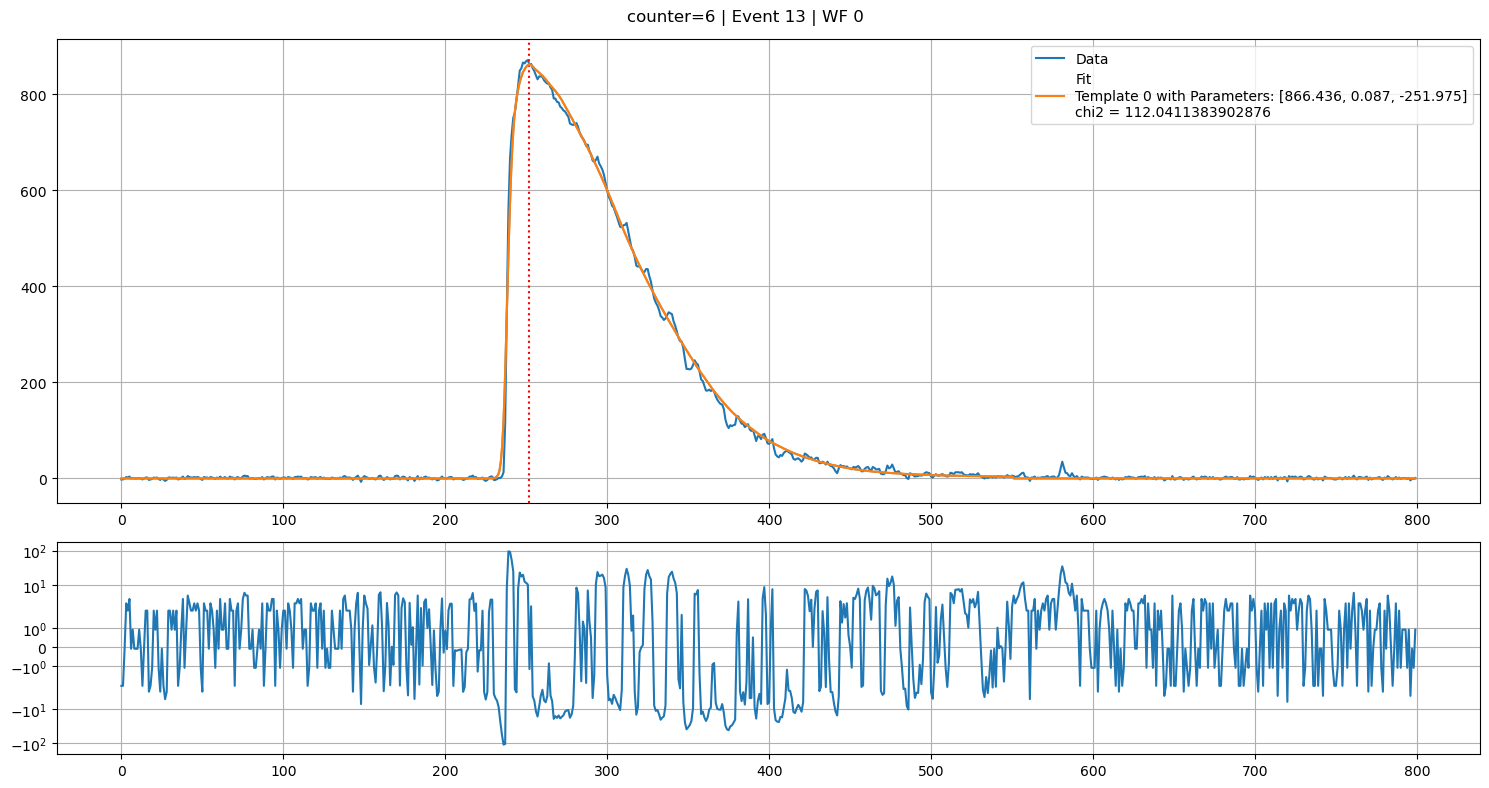

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


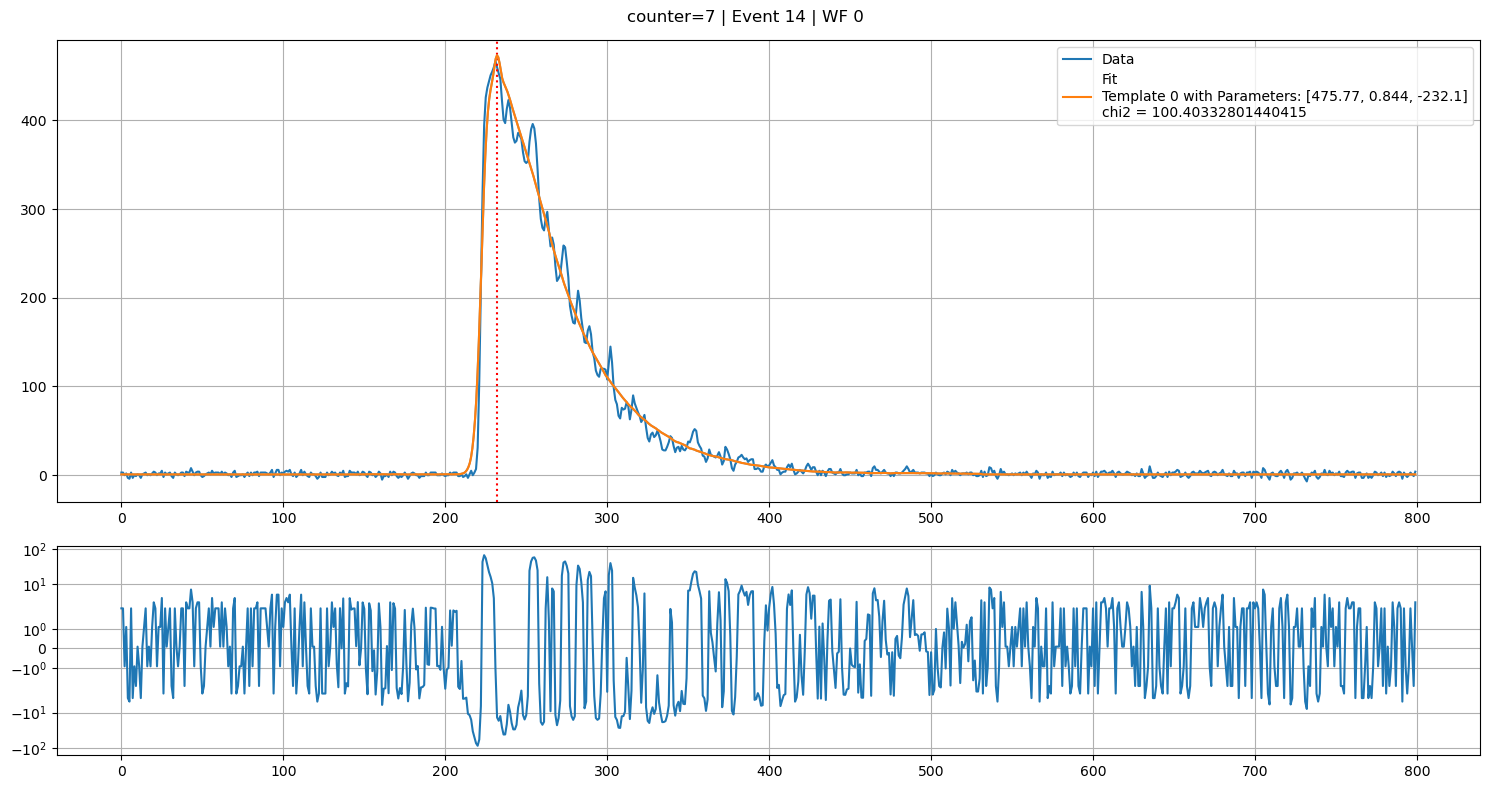

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}
{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


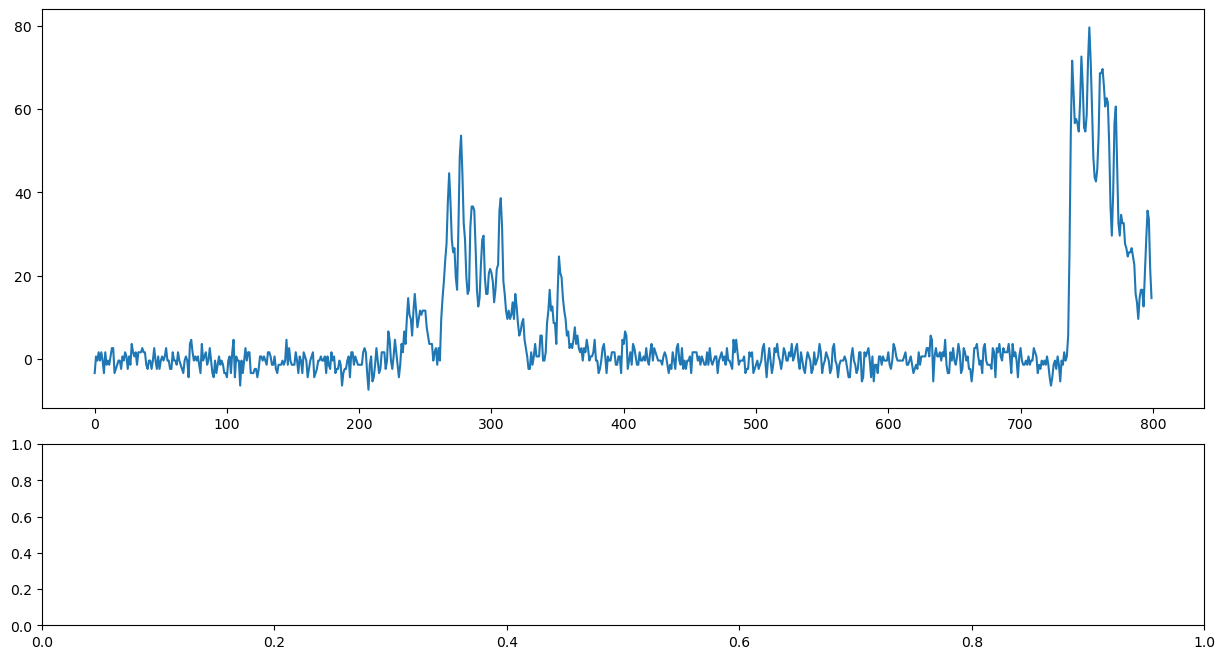

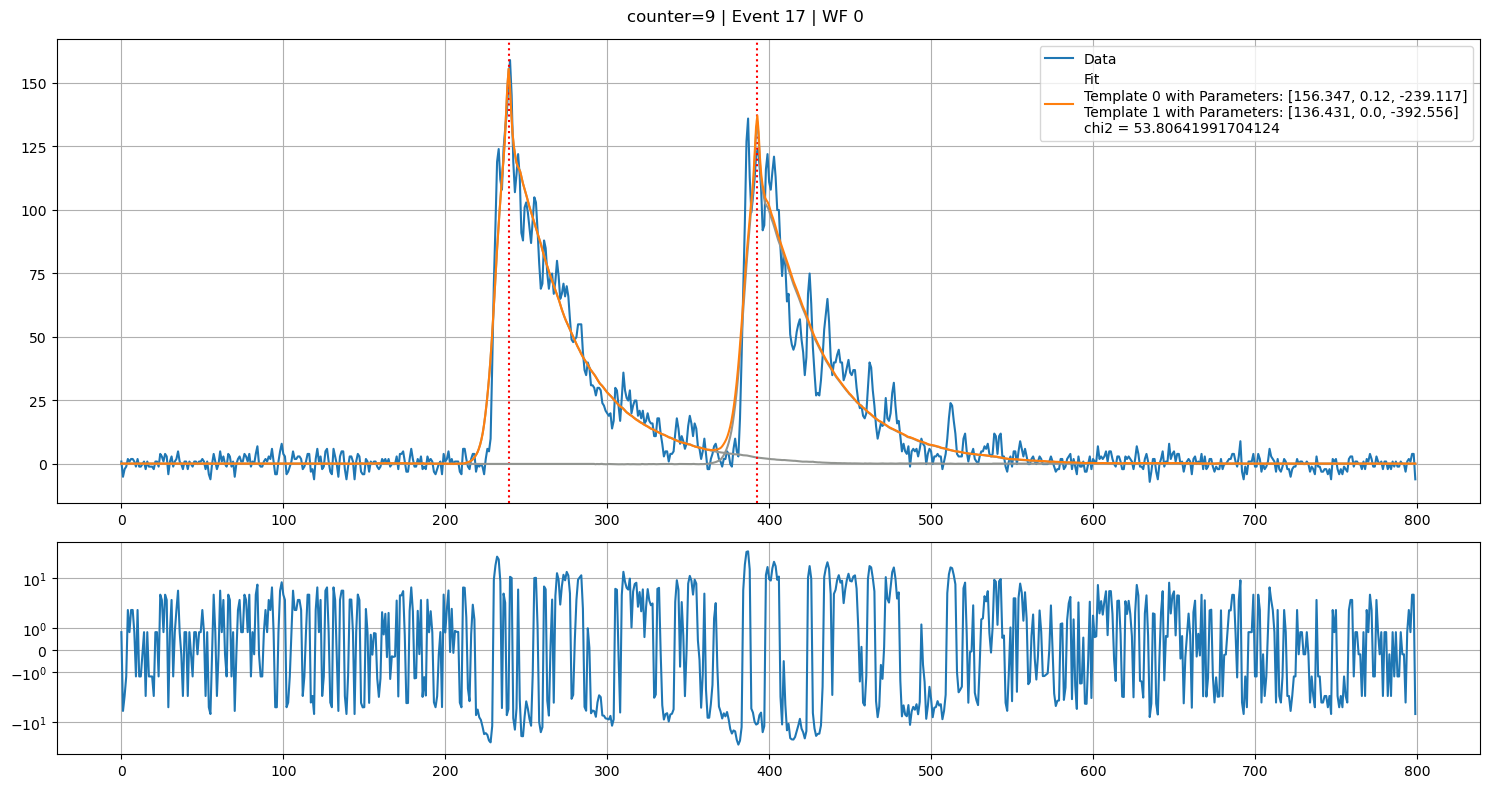

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


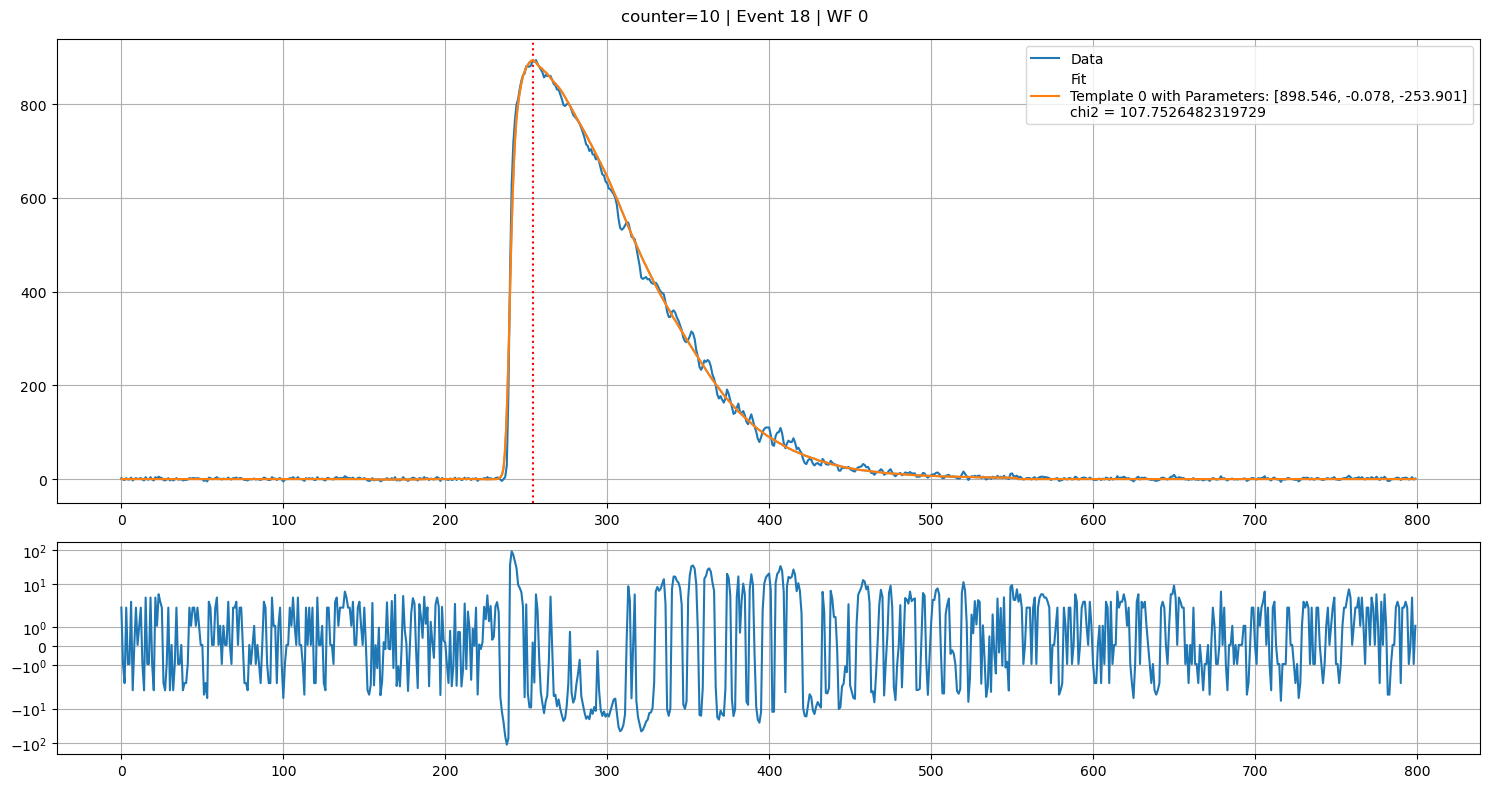

{'0': <Axes: label='0'>, '1': <Axes: label='1'>}


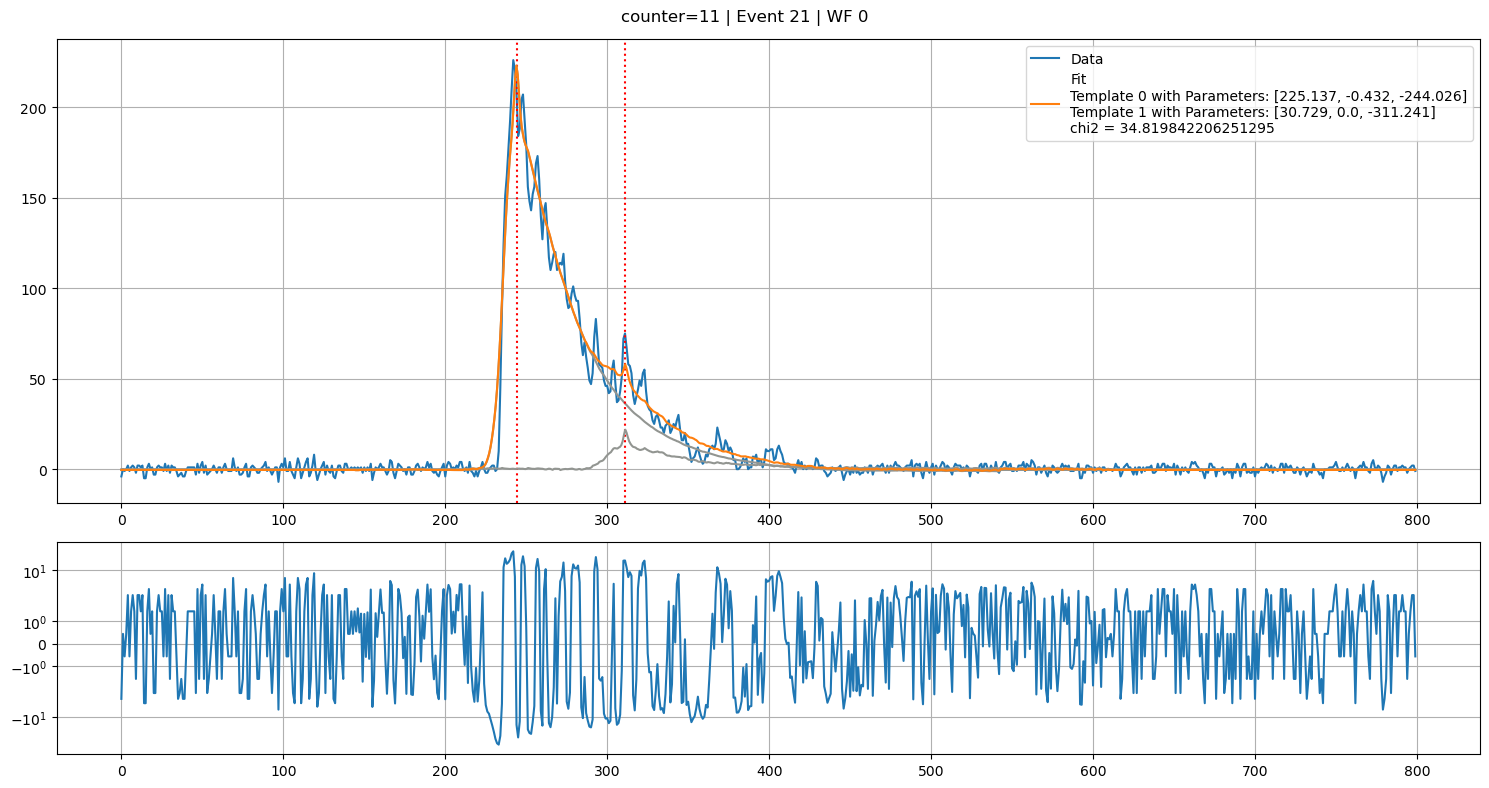

In [35]:
counter = 0
limit = 10
for i, e in enumerate(t):
    for j,wf in enumerate(e.lyso_integrals):
        if(wf.channelTag != channel):
            continue
        counter += 1
        trace = np.array(wf.raw.GetObject().trace,float) - wf.pedestalLevel
        samples = [i for i in range(len(trace))]
        data = np.array((samples,trace))
        fiti = TemplateFit(data, interp, minimum_energy=30, verbose=False)
        fiti.do_fit()
        try:
            fiti.plot()
            plt.suptitle(f'{counter=} | Event {i} | WF {j}')
            plt.tight_layout()
            plt.show()
        except:
            continue
    if(counter > limit):
        break

In [36]:
%%time 

counter = 0
limit = 1000
for i, e in enumerate(t):
    for j,wf in enumerate(e.lyso_integrals):
        if(wf.channelTag != channel):
            continue
        counter += 1
        trace = np.array(wf.raw.GetObject().trace,float) - wf.pedestalLevel
        samples = [i for i in range(len(trace))]
        data = np.array((samples,trace))
        fiti = TemplateFit(data, interp, minimum_energy=30, verbose=False)
        fiti.do_fit()
        # try:
        #     fiti.plot()
        #     plt.suptitle(f'{counter=} | Event {i} | WF {j}')
        #     plt.tight_layout()
        #     plt.show()
        # except:
        #     continue
    if(counter > limit):
        break

E VariableMetricBuilder Initial matrix not pos.def.
CPU times: user 3min 44s, sys: 3.57 s, total: 3min 47s
Wall time: 4min 6s


In [39]:
t.GetEntries()

9641

In [41]:
t.GetEntries()/1000. * (3*60 + 44)/60

35.993066666666664

In [42]:
36/34.

1.0588235294117647